# Exploring the radial properties of the hot-ICM density

We can infer the density of the hot baryon component of the intra-cluster medium through the use of X-ray observations. In this case we use surface brightness profiles to determine the 3D density profile of each cluster, assuming spherical symmetry.

<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented. Also also, we are still using the MCXC defined coordinates</span>

<span style="color:red">**We do not currently make the density profile saves available, as I need to create a better file format for them (i.e. FITS based), and they are probably too large for GitHub right now.**</span>

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
from matplotlib import pyplot as plt
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 50
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model

%matplotlib inline

In [2]:
!which python

/mnt/home/turne540/software/anaconda3/envs/xga_dev/bin/python


## Creating Storage Directories

We ensure that the storage directories within which we will store output files from this analysis have been created:

In [3]:
stor_dir = '../../outputs/results/profiles/density/'
if not os.path.exists(stor_dir):
    os.makedirs(stor_dir)
    
fig_dir = '../../outputs/figures/profiles/density/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
stor_dir_sb = '../../outputs/results/profiles/surface_brightness/'
if not os.path.exists(stor_dir_sb):
    os.makedirs(stor_dir_sb)
    
fig_dir_sb = '../../outputs/figures/profiles/surface_brightness/'
if not os.path.exists(fig_dir_sb):
    os.makedirs(fig_dir_sb)

## Define the cosmology

We make use of a concordance flat LambdaCDM cosmology during the course of this analysis:

In [4]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading the sample file

We read in the sample file to get the information we need to set up an XGA ClusterSample:

In [5]:
samp = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
rad_hist = pd.read_csv('../../outputs/results/ltr_r500_metfree_radii_history.csv')

samp = samp[~np.isnan(samp['r500'])]

temp_samp = samp.merge(rad_hist)
samp = samp[temp_samp['converged'].values]
samp

,name,ra,dec,redshift,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Lx500_0.4-2.4,Lx500_0.4-2.4-,Lx500_0.4-2.4+,Zmet500,Zmet500-,Zmet500+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,Lx500ce_0.4-2.4,Lx500ce_0.4-2.4-,Lx500ce_0.4-2.4+,Zmet500ce,Zmet500ce-,Zmet500ce+
3,LoVoCCS-4B,10.451487,-9.460007,0.0555,1144.764889,5.55319,0.049256,0.049231,6.827098e+43,2.376048e+42,1.631782e+42,2.323190e+44,7.937256e+42,6.504758e+42,8.728831e+43,2.514485e+42,2.364832e+42,0.211546,0.013172,0.013220,5.649450,0.050833,0.050805,5.588954e+43,2.263843e+42,2.262334e+42,1.917376e+44,5.887959e+42,5.199501e+42,7.148396e+43,2.249453e+42,2.175760e+42,2.148440e-01,1.389098e-02,0.013947
4,LoVoCCS-5,303.157313,-56.845978,0.0556,1119.049232,5.35600,0.044514,0.044392,1.603958e+44,7.309935e+42,6.470704e+42,5.365145e+44,2.800941e+43,2.237160e+43,2.049202e+44,8.969817e+42,9.452302e+42,0.202952,0.012255,0.012266,5.332650,0.054810,0.054678,1.099878e+44,6.902062e+42,8.983429e+42,3.665132e+44,2.810300e+43,1.507589e+43,1.405310e+44,1.059858e+43,8.959700e+42,1.787680e-01,1.477549e-02,0.014669
5,LoVoCCS-7,330.480000,-59.950000,0.0980,1149.344414,5.88148,0.063561,0.063588,3.036659e+44,1.317301e+42,9.510817e+41,1.065809e+45,5.885371e+42,6.795285e+42,3.887160e+44,1.697895e+42,1.515029e+42,0.239521,0.015216,0.015421,5.648660,0.083715,0.083644,2.024872e+44,1.160792e+42,1.082606e+42,6.952759e+44,6.718476e+42,5.090248e+42,2.590291e+44,1.123953e+42,1.297618e+42,1.986970e-01,2.072736e-02,0.020960
6,LoVoCCS-9,67.830487,-61.447401,0.0589,1209.871886,6.80800,0.045162,0.040867,1.551936e+44,2.095797e+42,2.155744e+42,5.779741e+44,6.922548e+42,7.161609e+42,1.993022e+44,2.706919e+42,2.048619e+42,0.182259,0.009428,0.009464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LoVoCCS-10,194.840000,-4.190000,0.0845,1129.503907,5.57022,0.089904,0.089403,3.010015e+44,1.873288e+42,1.386844e+42,1.033089e+45,8.300567e+42,9.731622e+42,3.847086e+44,2.420158e+42,2.185967e+42,0.289258,0.026268,0.026399,5.441610,0.133585,0.145661,1.886215e+44,1.467555e+42,1.376056e+42,6.349937e+44,9.826994e+42,9.161462e+42,2.411354e+44,2.040795e+42,1.746662e+42,1.727650e-01,3.694711e-02,0.037878
10,LoVoCCS-13,49.490000,-44.240000,0.0752,944.951945,4.04929,0.010001,0.008223,2.487713e+44,2.572661e+41,3.935470e+41,7.395135e+44,1.306181e+42,1.220603e+42,3.147113e+44,4.325164e+41,4.851989e+41,0.408156,0.003827,0.003683,4.175000,0.020869,0.020853,1.150769e+44,3.826278e+41,2.498732e+41,3.434262e+44,1.201204e+42,1.409299e+42,1.461498e+44,3.803062e+41,3.996260e+41,1.862520e-01,6.082948e-03,0.006151
12,LoVoCCS-15,351.330000,-12.130000,0.0852,892.237349,3.69158,0.009654,0.009652,2.497428e+44,5.977186e+41,5.825902e+41,7.091232e+44,1.514782e+42,1.692742e+42,3.155329e+44,7.925565e+41,7.076171e+41,0.307163,0.003473,0.003500,3.468040,0.020122,0.020179,1.007805e+44,3.536950e+41,3.119673e+41,2.774421e+44,1.322158e+42,1.459729e+42,1.274050e+44,4.665354e+41,5.780774e+41,1.691500e-01,6.379877e-03,0.006480
13,LoVoCCS-18,194.671250,-1.756944,0.0845,1043.615449,4.88707,0.035615,0.036800,2.626842e+44,6.617313e+41,5.368524e+41,8.445588e+44,2.696365e+42,3.308680e+42,3.348247e+44,6.193924e+41,8.766117e+41,0.228613,0.010306,0.010465,4.641090,0.052859,0.052812,1.601263e+44,5.053342e+41,5.073544e+41,4.993763e+44,3.915220e+42,3.025418e+42,2.040632e+44,6.994546e+41,6.546816e+41,1.239060e-01,1.386012e-02,0.014070
15,LoVoCCS-22,308.694130,-35.823600,0.0894,1010.640028,4.61534,0.086575,0.083052,1.808120e+44,9.295551e+41,1.238944e+42,5.628155e+44,5.714323e+42,5.529899e+42,2.303525e+44,1.300633e+42,1.624029e+42,0.133224,0.021775,0.022065,4.602970,0.101577,0.097804,1.488436e+44,1.231699e+42,1.133790e+42,4.628517e+44,6.766373e+42,4.815250e+42,1.896058e+44,1.196915e+42,1.289834e+42,1.367440e-01,2.642274e-02,0.025670
16,LoVoCCS-24,342.487500,-64.429444,0.0940,1039.992188,4.87439,0.047

In [6]:
# TODO OBVIOUSLY REMOVE THIS
samp = samp[:10]

## Set up an XGA ClusterSample

We set up an XGA ClusterSample to help us manage all the data and analyse the objects. <span style="color:red">The .... </span> coordinates are used as the central positions of the clusters, as well as the <span style="color:red"> .... </span> $R_{500}$ values.

<span style="color:red">The threshold for an observation being determined as relevant is set to 70% of the $R_{500}$ being on a particular observation.</span> 

In [7]:
ra = samp['ra'].values
dec = samp['dec'].values
name = samp['name'].values
z = samp['redshift'].values
r500 = Quantity(samp['r500'].values, 'kpc')

srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.7, cosmology=cosmo, load_fits=False)

Setting up Galaxy Clusters: 100%|██████████| 10/10 [01:39<00:00,  9.96s/it]
/tmp/local/36003467/ipykernel_17485/3875356751.py:7: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-4B, LoVoCCS-5, LoVoCCS-9
  srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500',
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


In [8]:
srcs.suppressed_warnings

{'LoVoCCS-7': ["LoVoCCS-7 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 'LoVoCCS-22': ['A point source has been detected in 0675470301 and is very close to the user supplied coordinates of LoVoCCS-22. It will not be excluded from analysis due to the possibility of a mis-identified cool core']}

In [9]:
srcs.info()


-----------------------------------------------------
Number of Sources - 7
Redshift Information - True
Sources with ≥1 detection - 7 [100%]
-----------------------------------------------------



## Richardson-Lucy spatially varying PSF correction 

Running the PSF correction of images necessary to create density profiles from surface brightness:

In [10]:
rl_psf(srcs, bins=10, num_cores=50)

## Density profiles from double-$\beta$ profile fits to $S_{\rm{B}}(r)$

In [11]:
# errors = """[[SASGenerationError("/bin/sh: line 1: 34223 Segmentation fault      (core dumped) rmfgen rmfset=0744411101_mos1_LoVoCCS-1_universal.rmf spectrumset='0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1."), SASGenerationError('/bin/sh: line 1: 34225 Segmentation fault      (core dumped) arfgen spectrumset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411101_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1.'), SASGenerationError('/bin/sh: line 1: 34278 Segmentation fault      (core dumped) backscale spectrumset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1.'), SASGenerationError('/bin/sh: line 1: 35646 Segmentation fault      (core dumped) specgroup spectrumset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411101_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1.'), SASGenerationError("/bin/sh: line 1: 34288 Segmentation fault      (core dumped) rmfgen rmfset=0744411101_mos2_LoVoCCS-1_universal.rmf spectrumset='0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2."), SASGenerationError('/bin/sh: line 1: 34295 Segmentation fault      (core dumped) arfgen spectrumset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411101_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2.'), SASGenerationError('/bin/sh: line 1: 34338 Segmentation fault      (core dumped) backscale spectrumset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2.'), SASGenerationError('/bin/sh: line 1: 35909 Segmentation fault      (core dumped) specgroup spectrumset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411101_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2.'), SASGenerationError("/bin/sh: line 1: 34323 Segmentation fault      (core dumped) rmfgen rmfset=0744410901_mos2_LoVoCCS-1_universal.rmf spectrumset='0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744410901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2."), SASGenerationError('/bin/sh: line 1: 34325 Segmentation fault      (core dumped) arfgen spectrumset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744410901_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744410901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2.'), SASGenerationError('/bin/sh: line 1: 34376 Segmentation fault      (core dumped) backscale spectrumset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2.'), SASGenerationError('/bin/sh: line 1: 35936 Segmentation fault      (core dumped) specgroup spectrumset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744410901_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2.'), SASGenerationError("/bin/sh: line 1: 34714 Segmentation fault      (core dumped) rmfgen rmfset=0744411201_mos1_LoVoCCS-1_universal.rmf spectrumset='0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1."), SASGenerationError('/bin/sh: line 1: 34717 Segmentation fault      (core dumped) arfgen spectrumset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411201_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('/bin/sh: line 1: 34737 Segmentation fault      (core dumped) backscale spectrumset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('/bin/sh: line 1: 35975 Segmentation fault      (core dumped) specgroup spectrumset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411201_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError("/bin/sh: line 1: 34749 Segmentation fault      (core dumped) rmfgen rmfset=0744411201_mos2_LoVoCCS-1_universal.rmf spectrumset='0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2."), SASGenerationError('/bin/sh: line 1: 34751 Segmentation fault      (core dumped) arfgen spectrumset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411201_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('/bin/sh: line 1: 34790 Segmentation fault      (core dumped) backscale spectrumset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('/bin/sh: line 1: 36213 Segmentation fault      (core dumped) specgroup spectrumset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411201_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError("/bin/sh: line 1: 34932 Segmentation fault      (core dumped) rmfgen rmfset=0822350101_mos2_LoVoCCS-1_universal.rmf spectrumset='0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0822350101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2."), SASGenerationError('/bin/sh: line 1: 34933 Segmentation fault      (core dumped) arfgen spectrumset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0822350101_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0822350101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError('/bin/sh: line 1: 35008 Segmentation fault      (core dumped) backscale spectrumset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError('/bin/sh: line 1: 36326 Segmentation fault      (core dumped) specgroup spectrumset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0822350101_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError("/bin/sh: line 1: 35256 Segmentation fault      (core dumped) rmfgen rmfset=0744411001_mos1_LoVoCCS-1_universal.rmf spectrumset='0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1."), SASGenerationError('/bin/sh: line 1: 35258 Segmentation fault      (core dumped) arfgen spectrumset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411001_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1.'), SASGenerationError('/bin/sh: line 1: 35289 Segmentation fault      (core dumped) backscale spectrumset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1.'), SASGenerationError('/bin/sh: line 1: 36604 Segmentation fault      (core dumped) specgroup spectrumset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411001_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1.'), SASGenerationError("/bin/sh: line 1: 34359 Segmentation fault      (core dumped) rmfgen rmfset=0744411101_pn_LoVoCCS-1_universal.rmf spectrumset='0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn."), SASGenerationError('/bin/sh: line 1: 34360 Segmentation fault      (core dumped) arfgen spectrumset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411101_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError('/bin/sh: line 1: 34505 Segmentation fault      (core dumped) backscale spectrumset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError('/bin/sh: line 1: 36805 Segmentation fault      (core dumped) specgroup spectrumset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411101_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError("/bin/sh: line 1: 35144 Segmentation fault      (core dumped) rmfgen rmfset=0744411001_mos2_LoVoCCS-1_universal.rmf spectrumset='0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2."), SASGenerationError('/bin/sh: line 1: 35145 Segmentation fault      (core dumped) arfgen spectrumset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411001_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2.'), SASGenerationError('/bin/sh: line 1: 35253 Segmentation fault      (core dumped) backscale spectrumset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2.'), SASGenerationError('/bin/sh: line 1: 36826 Segmentation fault      (core dumped) specgroup spectrumset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411001_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2.'), SASGenerationError("/bin/sh: line 1: 34436 Segmentation fault      (core dumped) rmfgen rmfset=0744410901_pn_LoVoCCS-1_universal.rmf spectrumset='0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744410901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn."), SASGenerationError('/bin/sh: line 1: 34437 Segmentation fault      (core dumped) arfgen spectrumset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744410901_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744410901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError('/bin/sh: line 1: 34566 Segmentation fault      (core dumped) backscale spectrumset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError('/bin/sh: line 1: 36924 Segmentation fault      (core dumped) specgroup spectrumset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744410901_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError("/bin/sh: line 1: 35915 Segmentation fault      (core dumped) rmfgen rmfset=0551780501_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1."), SASGenerationError('/bin/sh: line 1: 35917 Segmentation fault      (core dumped) arfgen spectrumset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780501_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1.'), SASGenerationError('/bin/sh: line 1: 36006 Segmentation fault      (core dumped) backscale spectrumset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1.'), SASGenerationError('/bin/sh: line 1: 38663 Segmentation fault      (core dumped) specgroup spectrumset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780501_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1.'), SASGenerationError("/bin/sh: line 1: 35169 Segmentation fault      (core dumped) rmfgen rmfset=0744411201_pn_LoVoCCS-1_universal.rmf spectrumset='0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn."), SASGenerationError('/bin/sh: line 1: 35171 Segmentation fault      (core dumped) arfgen spectrumset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411201_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError('/bin/sh: line 1: 35356 Segmentation fault      (core dumped) backscale spectrumset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError('/bin/sh: line 1: 38723 Segmentation fault      (core dumped) specgroup spectrumset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411201_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError("/bin/sh: line 1: 35840 Segmentation fault      (core dumped) rmfgen rmfset=0551780201_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1."), SASGenerationError('/bin/sh: line 1: 35842 Segmentation fault      (core dumped) arfgen spectrumset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780201_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1.'), SASGenerationError('/bin/sh: line 1: 36018 Segmentation fault      (core dumped) backscale spectrumset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1.'), SASGenerationError('/bin/sh: line 1: 38726 Segmentation fault      (core dumped) specgroup spectrumset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780201_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1.'), SASGenerationError("/bin/sh: line 1: 35927 Segmentation fault      (core dumped) rmfgen rmfset=0551780401_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1."), SASGenerationError('/bin/sh: line 1: 35928 Segmentation fault      (core dumped) arfgen spectrumset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780401_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1.'), SASGenerationError('/bin/sh: line 1: 36042 Segmentation fault      (core dumped) backscale spectrumset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1.'), SASGenerationError('/bin/sh: line 1: 38812 Segmentation fault      (core dumped) specgroup spectrumset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780401_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1.'), SASGenerationError("/bin/sh: line 1: 35964 Segmentation fault      (core dumped) rmfgen rmfset=0551780501_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2."), SASGenerationError('/bin/sh: line 1: 35966 Segmentation fault      (core dumped) arfgen spectrumset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780501_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2.'), SASGenerationError('/bin/sh: line 1: 36045 Segmentation fault      (core dumped) backscale spectrumset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2.'), SASGenerationError('/bin/sh: line 1: 38910 Segmentation fault      (core dumped) specgroup spectrumset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780501_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2.'), SASGenerationError("/bin/sh: line 1: 36165 Segmentation fault      (core dumped) rmfgen rmfset=0111270201_mos2_LoVoCCS-1_universal.rmf spectrumset='0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0111270201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2."), SASGenerationError('/bin/sh: line 1: 36166 Segmentation fault      (core dumped) arfgen spectrumset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0111270201_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0111270201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2.'), SASGenerationError('/bin/sh: line 1: 36201 Segmentation fault      (core dumped) backscale spectrumset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2.'), SASGenerationError('/bin/sh: line 1: 38935 Segmentation fault      (core dumped) specgroup spectrumset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0111270201_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2.'), SASGenerationError("/bin/sh: line 1: 35951 Segmentation fault      (core dumped) rmfgen rmfset=0551780201_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2."), SASGenerationError('/bin/sh: line 1: 35953 Segmentation fault      (core dumped) arfgen spectrumset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780201_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2.'), SASGenerationError('/bin/sh: line 1: 36121 Segmentation fault      (core dumped) backscale spectrumset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2.'), SASGenerationError('/bin/sh: line 1: 38942 Segmentation fault      (core dumped) specgroup spectrumset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780201_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2.'), SASGenerationError("/bin/sh: line 1: 35946 Segmentation fault      (core dumped) rmfgen rmfset=0551780401_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2."), SASGenerationError('/bin/sh: line 1: 35947 Segmentation fault      (core dumped) arfgen spectrumset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780401_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2.'), SASGenerationError('/bin/sh: line 1: 36066 Segmentation fault      (core dumped) backscale spectrumset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2.'), SASGenerationError('/bin/sh: line 1: 38965 Segmentation fault      (core dumped) specgroup spectrumset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780401_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2.'), SASGenerationError("/bin/sh: line 1: 36152 Segmentation fault      (core dumped) rmfgen rmfset=0111270201_mos1_LoVoCCS-1_universal.rmf spectrumset='0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0111270201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1."), SASGenerationError('/bin/sh: line 1: 36153 Segmentation fault      (core dumped) arfgen spectrumset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0111270201_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0111270201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1.'), SASGenerationError('/bin/sh: line 1: 36172 Segmentation fault      (core dumped) backscale spectrumset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1.'), SASGenerationError('/bin/sh: line 1: 39092 Segmentation fault      (core dumped) specgroup spectrumset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0111270201_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1.'), SASGenerationError("/bin/sh: line 1: 36244 Segmentation fault      (core dumped) rmfgen rmfset=0551780301_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1."), SASGenerationError('/bin/sh: line 1: 36247 Segmentation fault      (core dumped) arfgen spectrumset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780301_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1.'), SASGenerationError('/bin/sh: line 1: 36380 Segmentation fault      (core dumped) backscale spectrumset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1.'), SASGenerationError('/bin/sh: line 1: 39107 Segmentation fault      (core dumped) specgroup spectrumset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780301_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1.'), SASGenerationError("/bin/sh: line 1: 35563 Segmentation fault      (core dumped) rmfgen rmfset=0822350101_pn_LoVoCCS-1_universal.rmf spectrumset='0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0822350101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn."), SASGenerationError('/bin/sh: line 1: 35565 Segmentation fault      (core dumped) arfgen spectrumset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0822350101_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0822350101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError('/bin/sh: line 1: 35804 Segmentation fault      (core dumped) backscale spectrumset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError('/bin/sh: line 1: 39138 Segmentation fault      (core dumped) specgroup spectrumset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0822350101_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError("/bin/sh: line 1: 36362 Segmentation fault      (core dumped) rmfgen rmfset=0551780301_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2."), SASGenerationError('/bin/sh: line 1: 36363 Segmentation fault      (core dumped) arfgen spectrumset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780301_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2.'), SASGenerationError('/bin/sh: line 1: 36449 Segmentation fault      (core dumped) backscale spectrumset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2.'), SASGenerationError('/bin/sh: line 1: 39375 Segmentation fault      (core dumped) specgroup spectrumset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780301_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2.'), SASGenerationError("/bin/sh: line 1: 35791 Segmentation fault      (core dumped) rmfgen rmfset=0744411001_pn_LoVoCCS-1_universal.rmf spectrumset='0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411001_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn."), SASGenerationError('/bin/sh: line 1: 35792 Segmentation fault      (core dumped) arfgen spectrumset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411001_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411001_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError('/bin/sh: line 1: 36017 Segmentation fault      (core dumped) backscale spectrumset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError('/bin/sh: line 1: 39656 Segmentation fault      (core dumped) specgroup spectrumset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411001_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError("/bin/sh: line 1: 36241 Segmentation fault      (core dumped) rmfgen rmfset=0551780201_pn_LoVoCCS-1_universal.rmf spectrumset='0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn."), SASGenerationError('/bin/sh: line 1: 36242 Segmentation fault      (core dumped) arfgen spectrumset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780201_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn.'), SASGenerationError('/bin/sh: line 1: 36551 Segmentation fault      (core dumped) backscale spectrumset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn.'), SASGenerationError('/bin/sh: line 1: 40242 Segmentation fault      (core dumped) specgroup spectrumset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780201_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn.'), SASGenerationError("/bin/sh: line 1: 36349 Segmentation fault      (core dumped) rmfgen rmfset=0551780401_pn_LoVoCCS-1_universal.rmf spectrumset='0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn."), SASGenerationError('/bin/sh: line 1: 36350 Segmentation fault      (core dumped) arfgen spectrumset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780401_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn.'), SASGenerationError('/bin/sh: line 1: 36572 Segmentation fault      (core dumped) backscale spectrumset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn.'), SASGenerationError('/bin/sh: line 1: 40254 Segmentation fault      (core dumped) specgroup spectrumset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780401_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn.'), SASGenerationError("/bin/sh: line 1: 36481 Segmentation fault      (core dumped) rmfgen rmfset=0551780501_pn_LoVoCCS-1_universal.rmf spectrumset='0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn."), SASGenerationError('/bin/sh: line 1: 36482 Segmentation fault      (core dumped) arfgen spectrumset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780501_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn.'), SASGenerationError('/bin/sh: line 1: 36816 Segmentation fault      (core dumped) backscale spectrumset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn.'), SASGenerationError('/bin/sh: line 1: 40600 Segmentation fault      (core dumped) specgroup spectrumset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780501_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn.'), SASGenerationError("/bin/sh: line 1: 36897 Segmentation fault      (core dumped) rmfgen rmfset=0551780301_pn_LoVoCCS-1_universal.rmf spectrumset='0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn."), SASGenerationError('/bin/sh: line 1: 36899 Segmentation fault      (core dumped) arfgen spectrumset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780301_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn.'), SASGenerationError('/bin/sh: line 1: 37254 Segmentation fault      (core dumped) backscale spectrumset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn.'), SASGenerationError('/bin/sh: line 1: 41035 Segmentation fault      (core dumped) specgroup spectrumset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780301_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn.'), SASGenerationError("/bin/sh: line 1: 38869 Segmentation fault      (core dumped) rmfgen rmfset=0111270201_pn_LoVoCCS-1_universal.rmf spectrumset='0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0111270201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn."), SASGenerationError('/bin/sh: line 1: 38875 Segmentation fault      (core dumped) arfgen spectrumset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0111270201_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0111270201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn.'), SASGenerationError('/bin/sh: line 1: 40545 Segmentation fault      (core dumped) backscale spectrumset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn.'), SASGenerationError('/bin/sh: line 1: 43637 Segmentation fault      (core dumped) specgroup spectrumset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0111270201_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn.')], [SASGenerationError("/bin/sh: line 1: 34532 Segmentation fault      (core dumped) rmfgen rmfset=0744411701_mos1_LoVoCCS-4_universal.rmf spectrumset='0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1."), SASGenerationError('/bin/sh: line 1: 34533 Segmentation fault      (core dumped) arfgen spectrumset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411701_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1.'), SASGenerationError('/bin/sh: line 1: 34569 Segmentation fault      (core dumped) backscale spectrumset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1.'), SASGenerationError('/bin/sh: line 1: 36081 Segmentation fault      (core dumped) specgroup spectrumset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411701_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1.'), SASGenerationError("/bin/sh: line 1: 34603 Segmentation fault      (core dumped) rmfgen rmfset=0744411901_mos1_LoVoCCS-4_universal.rmf spectrumset='0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1."), SASGenerationError('/bin/sh: line 1: 34604 Segmentation fault      (core dumped) arfgen spectrumset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411901_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1.'), SASGenerationError('/bin/sh: line 1: 34646 Segmentation fault      (core dumped) backscale spectrumset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1.'), SASGenerationError('/bin/sh: line 1: 36134 Segmentation fault      (core dumped) specgroup spectrumset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411901_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1.'), SASGenerationError("/bin/sh: line 1: 34492 Segmentation fault      (core dumped) rmfgen rmfset=0065140201_mos2_LoVoCCS-4_universal.rmf spectrumset='0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2."), SASGenerationError('/bin/sh: line 1: 34493 Segmentation fault      (core dumped) arfgen spectrumset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140201_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError('/bin/sh: line 1: 34516 Segmentation fault      (core dumped) backscale spectrumset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError('/bin/sh: line 1: 36158 Segmentation fault      (core dumped) specgroup spectrumset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140201_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError("/bin/sh: line 1: 34499 Segmentation fault      (core dumped) rmfgen rmfset=0065140201_mos1_LoVoCCS-4_universal.rmf spectrumset='0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1."), SASGenerationError('/bin/sh: line 1: 34500 Segmentation fault      (core dumped) arfgen spectrumset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140201_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('/bin/sh: line 1: 34519 Segmentation fault      (core dumped) backscale spectrumset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('/bin/sh: line 1: 36222 Segmentation fault      (core dumped) specgroup spectrumset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140201_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError("/bin/sh: line 1: 34762 Segmentation fault      (core dumped) rmfgen rmfset=0744411801_mos1_LoVoCCS-4_universal.rmf spectrumset='0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1."), SASGenerationError('/bin/sh: line 1: 34763 Segmentation fault      (core dumped) arfgen spectrumset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411801_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1.'), SASGenerationError('/bin/sh: line 1: 34826 Segmentation fault      (core dumped) backscale spectrumset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1.'), SASGenerationError('/bin/sh: line 1: 36330 Segmentation fault      (core dumped) specgroup spectrumset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411801_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1.'), SASGenerationError("/bin/sh: line 1: 34579 Segmentation fault      (core dumped) rmfgen rmfset=0744411701_mos2_LoVoCCS-4_universal.rmf spectrumset='0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2."), SASGenerationError('/bin/sh: line 1: 34580 Segmentation fault      (core dumped) arfgen spectrumset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411701_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2.'), SASGenerationError('/bin/sh: line 1: 34612 Segmentation fault      (core dumped) backscale spectrumset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2.'), SASGenerationError('/bin/sh: line 1: 36337 Segmentation fault      (core dumped) specgroup spectrumset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411701_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2.'), SASGenerationError("/bin/sh: line 1: 34708 Segmentation fault      (core dumped) rmfgen rmfset=0744411901_mos2_LoVoCCS-4_universal.rmf spectrumset='0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2."), SASGenerationError('/bin/sh: line 1: 34709 Segmentation fault      (core dumped) arfgen spectrumset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411901_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2.'), SASGenerationError('/bin/sh: line 1: 34746 Segmentation fault      (core dumped) backscale spectrumset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2.'), SASGenerationError('/bin/sh: line 1: 36430 Segmentation fault      (core dumped) specgroup spectrumset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411901_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2.'), SASGenerationError("/bin/sh: line 1: 34927 Segmentation fault      (core dumped) rmfgen rmfset=0744930301_mos1_LoVoCCS-4_universal.rmf spectrumset='0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1."), SASGenerationError('/bin/sh: line 1: 34928 Segmentation fault      (core dumped) arfgen spectrumset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930301_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1.'), SASGenerationError('/bin/sh: line 1: 34989 Segmentation fault      (core dumped) backscale spectrumset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1.'), SASGenerationError('/bin/sh: line 1: 36439 Segmentation fault      (core dumped) specgroup spectrumset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744930301_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1.'), SASGenerationError("/bin/sh: line 1: 35170 Segmentation fault      (core dumped) rmfgen rmfset=0065140101_mos2_LoVoCCS-4_universal.rmf spectrumset='0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2."), SASGenerationError('/bin/sh: line 1: 35172 Segmentation fault      (core dumped) arfgen spectrumset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140101_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2.'), SASGenerationError('/bin/sh: line 1: 35264 Segmentation fault      (core dumped) backscale spectrumset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2.'), SASGenerationError('/bin/sh: line 1: 36450 Segmentation fault      (core dumped) specgroup spectrumset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140101_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2.'), SASGenerationError("/bin/sh: line 1: 35181 Segmentation fault      (core dumped) rmfgen rmfset=0065140101_mos1_LoVoCCS-4_universal.rmf spectrumset='0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1."), SASGenerationError('/bin/sh: line 1: 35184 Segmentation fault      (core dumped) arfgen spectrumset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140101_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1.'), SASGenerationError('/bin/sh: line 1: 35285 Segmentation fault      (core dumped) backscale spectrumset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1.'), SASGenerationError('/bin/sh: line 1: 36465 Segmentation fault      (core dumped) specgroup spectrumset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140101_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1.'), SASGenerationError("/bin/sh: line 1: 34767 Segmentation fault      (core dumped) rmfgen rmfset=0744411801_mos2_LoVoCCS-4_universal.rmf spectrumset='0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2."), SASGenerationError('/bin/sh: line 1: 34768 Segmentation fault      (core dumped) arfgen spectrumset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411801_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2.'), SASGenerationError('/bin/sh: line 1: 34828 Segmentation fault      (core dumped) backscale spectrumset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2.'), SASGenerationError('/bin/sh: line 1: 36486 Segmentation fault      (core dumped) specgroup spectrumset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411801_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2.'), SASGenerationError("/bin/sh: line 1: 35075 Segmentation fault      (core dumped) rmfgen rmfset=0744930301_mos2_LoVoCCS-4_universal.rmf spectrumset='0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2."), SASGenerationError('/bin/sh: line 1: 35077 Segmentation fault      (core dumped) arfgen spectrumset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930301_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2.'), SASGenerationError('/bin/sh: line 1: 35135 Segmentation fault      (core dumped) backscale spectrumset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2.'), SASGenerationError('/bin/sh: line 1: 36788 Segmentation fault      (core dumped) specgroup spectrumset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744930301_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2.'), SASGenerationError("/bin/sh: line 1: 34792 Segmentation fault      (core dumped) rmfgen rmfset=0065140201_pn_LoVoCCS-4_universal.rmf spectrumset='0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn."), SASGenerationError('/bin/sh: line 1: 34794 Segmentation fault      (core dumped) arfgen spectrumset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140201_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('/bin/sh: line 1: 34936 Segmentation fault      (core dumped) backscale spectrumset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('/bin/sh: line 1: 37219 Segmentation fault      (core dumped) specgroup spectrumset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140201_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError("/bin/sh: line 1: 34890 Segmentation fault      (core dumped) rmfgen rmfset=0744411701_pn_LoVoCCS-4_universal.rmf spectrumset='0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn."), SASGenerationError('/bin/sh: line 1: 34891 Segmentation fault      (core dumped) arfgen spectrumset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411701_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError('/bin/sh: line 1: 35063 Segmentation fault      (core dumped) backscale spectrumset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError('/bin/sh: line 1: 37451 Segmentation fault      (core dumped) specgroup spectrumset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411701_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError("/bin/sh: line 1: 35117 Segmentation fault      (core dumped) rmfgen rmfset=0744411801_pn_LoVoCCS-4_universal.rmf spectrumset='0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn."), SASGenerationError('/bin/sh: line 1: 35118 Segmentation fault      (core dumped) arfgen spectrumset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411801_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn.'), SASGenerationError('/bin/sh: line 1: 35337 Segmentation fault      (core dumped) backscale spectrumset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn.'), SASGenerationError('/bin/sh: line 1: 38853 Segmentation fault      (core dumped) specgroup spectrumset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411801_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn.'), SASGenerationError("/bin/sh: line 1: 35066 Segmentation fault      (core dumped) rmfgen rmfset=0744411901_pn_LoVoCCS-4_universal.rmf spectrumset='0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn."), SASGenerationError('/bin/sh: line 1: 35067 Segmentation fault      (core dumped) arfgen spectrumset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411901_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError('/bin/sh: line 1: 35293 Segmentation fault      (core dumped) backscale spectrumset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError('/bin/sh: line 1: 38887 Segmentation fault      (core dumped) specgroup spectrumset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411901_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError("/bin/sh: line 1: 35639 Segmentation fault      (core dumped) rmfgen rmfset=0065140101_pn_LoVoCCS-4_universal.rmf spectrumset='0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn."), SASGenerationError('/bin/sh: line 1: 35640 Segmentation fault      (core dumped) arfgen spectrumset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140101_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn.'), SASGenerationError('/bin/sh: line 1: 35827 Segmentation fault      (core dumped) backscale spectrumset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn.'), SASGenerationError('/bin/sh: line 1: 39117 Segmentation fault      (core dumped) specgroup spectrumset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140101_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn.'), SASGenerationError("/bin/sh: line 1: 37029 Segmentation fault      (core dumped) rmfgen rmfset=0723802101_mos1_LoVoCCS-4_universal.rmf spectrumset='0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1."), SASGenerationError('/bin/sh: line 1: 37030 Segmentation fault      (core dumped) arfgen spectrumset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802101_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1.'), SASGenerationError('/bin/sh: line 1: 37227 Segmentation fault      (core dumped) backscale spectrumset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1.'), SASGenerationError('/bin/sh: line 1: 39344 Segmentation fault      (core dumped) specgroup spectrumset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802101_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1.'), SASGenerationError("/bin/sh: line 1: 35602 Segmentation fault      (core dumped) rmfgen rmfset=0744930301_pn_LoVoCCS-4_universal.rmf spectrumset='0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn."), SASGenerationError('/bin/sh: line 1: 35603 Segmentation fault      (core dumped) arfgen spectrumset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930301_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn.'), SASGenerationError('/bin/sh: line 1: 35801 Segmentation fault      (core dumped) backscale spectrumset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn.'), SASGenerationError('/bin/sh: line 1: 39445 Segmentation fault      (core dumped) specgroup spectrumset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744930301_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn.'), SASGenerationError("/bin/sh: line 1: 37248 Segmentation fault      (core dumped) rmfgen rmfset=0723802201_mos1_LoVoCCS-4_universal.rmf spectrumset='0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1."), SASGenerationError('/bin/sh: line 1: 37249 Segmentation fault      (core dumped) arfgen spectrumset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802201_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1.'), SASGenerationError('/bin/sh: line 1: 38608 Segmentation fault      (core dumped) backscale spectrumset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1.'), SASGenerationError('/bin/sh: line 1: 39684 Segmentation fault      (core dumped) specgroup spectrumset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802201_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1.'), SASGenerationError("/bin/sh: line 1: 37146 Segmentation fault      (core dumped) rmfgen rmfset=0723802101_mos2_LoVoCCS-4_universal.rmf spectrumset='0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2."), SASGenerationError('/bin/sh: line 1: 37160 Segmentation fault      (core dumped) arfgen spectrumset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802101_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2.'), SASGenerationError('/bin/sh: line 1: 38646 Segmentation fault      (core dumped) backscale spectrumset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2.'), SASGenerationError('/bin/sh: line 1: 40063 Segmentation fault      (core dumped) specgroup spectrumset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802101_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2.'), SASGenerationError("/bin/sh: line 1: 37373 Segmentation fault      (core dumped) rmfgen rmfset=0723802201_mos2_LoVoCCS-4_universal.rmf spectrumset='0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2."), SASGenerationError('/bin/sh: line 1: 37374 Segmentation fault      (core dumped) arfgen spectrumset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802201_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2.'), SASGenerationError('/bin/sh: line 1: 38729 Segmentation fault      (core dumped) backscale spectrumset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2.'), SASGenerationError('/bin/sh: line 1: 40136 Segmentation fault      (core dumped) specgroup spectrumset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802201_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2.'), SASGenerationError("/bin/sh: line 1: 41104 Segmentation fault      (core dumped) rmfgen rmfset=0723802101_pn_LoVoCCS-4_universal.rmf spectrumset='0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn."), SASGenerationError('/bin/sh: line 1: 41105 Segmentation fault      (core dumped) arfgen spectrumset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802101_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn.'), SASGenerationError('/bin/sh: line 1: 41726 Segmentation fault      (core dumped) backscale spectrumset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn.'), SASGenerationError('/bin/sh: line 1: 43978 Segmentation fault      (core dumped) specgroup spectrumset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802101_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn.'), SASGenerationError("/bin/sh: line 1: 41664 Segmentation fault      (core dumped) rmfgen rmfset=0723802201_pn_LoVoCCS-4_universal.rmf spectrumset='0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn."), SASGenerationError('/bin/sh: line 1: 41665 Segmentation fault      (core dumped) arfgen spectrumset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802201_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn.'), SASGenerationError('/bin/sh: line 1: 42009 Segmentation fault      (core dumped) backscale spectrumset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn.'), SASGenerationError('/bin/sh: line 1: 44438 Segmentation fault      (core dumped) specgroup spectrumset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802201_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn.')], [SASGenerationError("/bin/sh: line 1: 34183 Segmentation fault      (core dumped) rmfgen rmfset=0821270601_mos2_LoVoCCS-10_universal.rmf spectrumset='0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0821270601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2."), SASGenerationError('/bin/sh: line 1: 34184 Segmentation fault      (core dumped) arfgen spectrumset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0821270601_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0821270601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0821270601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError('/bin/sh: line 1: 34233 Segmentation fault      (core dumped) backscale spectrumset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0821270601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError('/bin/sh: line 1: 36354 Segmentation fault      (core dumped) specgroup spectrumset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0821270601_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError("/bin/sh: line 1: 34120 Segmentation fault      (core dumped) rmfgen rmfset=0844050201_mos1_LoVoCCS-10_universal.rmf spectrumset='0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1."), SASGenerationError('/bin/sh: line 1: 34121 Segmentation fault      (core dumped) arfgen spectrumset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050201_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1.'), SASGenerationError('/bin/sh: line 1: 34177 Segmentation fault      (core dumped) backscale spectrumset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1.'), SASGenerationError('/bin/sh: line 1: 36367 Segmentation fault      (core dumped) specgroup spectrumset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050201_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1.'), SASGenerationError("/bin/sh: line 1: 34251 Segmentation fault      (core dumped) rmfgen rmfset=0844050201_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2."), SASGenerationError('/bin/sh: line 1: 34255 Segmentation fault      (core dumped) arfgen spectrumset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050201_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2.'), SASGenerationError('/bin/sh: line 1: 34348 Segmentation fault      (core dumped) backscale spectrumset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2.'), SASGenerationError('/bin/sh: line 1: 36914 Segmentation fault      (core dumped) specgroup spectrumset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050201_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2.'), SASGenerationError("/bin/sh: line 1: 34248 Segmentation fault      (core dumped) rmfgen rmfset=0136740201_mos2_LoVoCCS-10_universal.rmf spectrumset='0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2."), SASGenerationError('/bin/sh: line 1: 34250 Segmentation fault      (core dumped) arfgen spectrumset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740201_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2.'), SASGenerationError('/bin/sh: line 1: 34319 Segmentation fault      (core dumped) backscale spectrumset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2.'), SASGenerationError('/bin/sh: line 1: 36994 Segmentation fault      (core dumped) specgroup spectrumset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740201_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2.'), SASGenerationError("/bin/sh: line 1: 34234 Segmentation fault      (core dumped) rmfgen rmfset=0136740201_mos1_LoVoCCS-10_universal.rmf spectrumset='0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1."), SASGenerationError('/bin/sh: line 1: 34236 Segmentation fault      (core dumped) arfgen spectrumset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740201_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1.'), SASGenerationError('/bin/sh: line 1: 34305 Segmentation fault      (core dumped) backscale spectrumset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1.'), SASGenerationError('/bin/sh: line 1: 37002 Segmentation fault      (core dumped) specgroup spectrumset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740201_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1.'), SASGenerationError("/bin/sh: line 1: 35032 Segmentation fault      (core dumped) rmfgen rmfset=0844050301_mos1_LoVoCCS-10_universal.rmf spectrumset='0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1."), SASGenerationError('/bin/sh: line 1: 35033 Segmentation fault      (core dumped) arfgen spectrumset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050301_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1.'), SASGenerationError('/bin/sh: line 1: 35078 Segmentation fault      (core dumped) backscale spectrumset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1.'), SASGenerationError('/bin/sh: line 1: 37082 Segmentation fault      (core dumped) specgroup spectrumset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050301_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1.'), SASGenerationError("/bin/sh: line 1: 34639 Segmentation fault      (core dumped) rmfgen rmfset=0112950401_mos1_LoVoCCS-10_universal.rmf spectrumset='0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1."), SASGenerationError('/bin/sh: line 1: 34642 Segmentation fault      (core dumped) arfgen spectrumset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950401_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1.'), SASGenerationError('/bin/sh: line 1: 34778 Segmentation fault      (core dumped) backscale spectrumset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1.'), SASGenerationError('/bin/sh: line 1: 37125 Segmentation fault      (core dumped) specgroup spectrumset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950401_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1.'), SASGenerationError("/bin/sh: line 1: 34829 Segmentation fault      (core dumped) rmfgen rmfset=0556200301_mos1_LoVoCCS-10_universal.rmf spectrumset='0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1."), SASGenerationError('/bin/sh: line 1: 34830 Segmentation fault      (core dumped) arfgen spectrumset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200301_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1.'), SASGenerationError('/bin/sh: line 1: 34874 Segmentation fault      (core dumped) backscale spectrumset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1.'), SASGenerationError('/bin/sh: line 1: 37133 Segmentation fault      (core dumped) specgroup spectrumset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200301_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1.'), SASGenerationError("/bin/sh: line 1: 34620 Segmentation fault      (core dumped) rmfgen rmfset=0112950401_mos2_LoVoCCS-10_universal.rmf spectrumset='0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2."), SASGenerationError('/bin/sh: line 1: 34621 Segmentation fault      (core dumped) arfgen spectrumset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950401_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2.'), SASGenerationError('/bin/sh: line 1: 34743 Segmentation fault      (core dumped) backscale spectrumset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2.'), SASGenerationError('/bin/sh: line 1: 37240 Segmentation fault      (core dumped) specgroup spectrumset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950401_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2.'), SASGenerationError("/bin/sh: line 1: 34784 Segmentation fault      (core dumped) rmfgen rmfset=0112950301_mos2_LoVoCCS-10_universal.rmf spectrumset='0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2."), SASGenerationError('/bin/sh: line 1: 34786 Segmentation fault      (core dumped) arfgen spectrumset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950301_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2.'), SASGenerationError('/bin/sh: line 1: 34864 Segmentation fault      (core dumped) backscale spectrumset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2.'), SASGenerationError('/bin/sh: line 1: 37295 Segmentation fault      (core dumped) specgroup spectrumset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950301_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2.'), SASGenerationError("/bin/sh: line 1: 34772 Segmentation fault      (core dumped) rmfgen rmfset=0844050101_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2."), SASGenerationError('/bin/sh: line 1: 34774 Segmentation fault      (core dumped) arfgen spectrumset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050101_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2.'), SASGenerationError('/bin/sh: line 1: 34851 Segmentation fault      (core dumped) backscale spectrumset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2.'), SASGenerationError('/bin/sh: line 1: 37344 Segmentation fault      (core dumped) specgroup spectrumset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050101_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2.'), SASGenerationError("/bin/sh: line 1: 34793 Segmentation fault      (core dumped) rmfgen rmfset=0112950301_mos1_LoVoCCS-10_universal.rmf spectrumset='0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1."), SASGenerationError('/bin/sh: line 1: 34807 Segmentation fault      (core dumped) arfgen spectrumset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950301_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1.'), SASGenerationError('/bin/sh: line 1: 34870 Segmentation fault      (core dumped) backscale spectrumset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1.'), SASGenerationError('/bin/sh: line 1: 37345 Segmentation fault      (core dumped) specgroup spectrumset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950301_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1.'), SASGenerationError("/bin/sh: line 1: 35085 Segmentation fault      (core dumped) rmfgen rmfset=0136740101_mos2_LoVoCCS-10_universal.rmf spectrumset='0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2."), SASGenerationError('/bin/sh: line 1: 35088 Segmentation fault      (core dumped) arfgen spectrumset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740101_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2.'), SASGenerationError('/bin/sh: line 1: 35229 Segmentation fault      (core dumped) backscale spectrumset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2.'), SASGenerationError('/bin/sh: line 1: 38623 Segmentation fault      (core dumped) specgroup spectrumset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740101_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2.'), SASGenerationError("/bin/sh: line 1: 35130 Segmentation fault      (core dumped) rmfgen rmfset=0844050401_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2."), SASGenerationError('/bin/sh: line 1: 35132 Segmentation fault      (core dumped) arfgen spectrumset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050401_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2.'), SASGenerationError('/bin/sh: line 1: 35183 Segmentation fault      (core dumped) backscale spectrumset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2.'), SASGenerationError('/bin/sh: line 1: 38634 Segmentation fault      (core dumped) specgroup spectrumset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050401_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2.'), SASGenerationError("/bin/sh: line 1: 34855 Segmentation fault      (core dumped) rmfgen rmfset=0556200301_mos2_LoVoCCS-10_universal.rmf spectrumset='0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2."), SASGenerationError('/bin/sh: line 1: 34856 Segmentation fault      (core dumped) arfgen spectrumset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200301_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2.'), SASGenerationError('/bin/sh: line 1: 34896 Segmentation fault      (core dumped) backscale spectrumset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2.'), SASGenerationError('/bin/sh: line 1: 38647 Segmentation fault      (core dumped) specgroup spectrumset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200301_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2.'), SASGenerationError("/bin/sh: line 1: 35097 Segmentation fault      (core dumped) rmfgen rmfset=0136740101_mos1_LoVoCCS-10_universal.rmf spectrumset='0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1."), SASGenerationError('/bin/sh: line 1: 35098 Segmentation fault      (core dumped) arfgen spectrumset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740101_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1.'), SASGenerationError('/bin/sh: line 1: 35178 Segmentation fault      (core dumped) backscale spectrumset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1.'), SASGenerationError('/bin/sh: line 1: 38651 Segmentation fault      (core dumped) specgroup spectrumset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740101_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1.'), SASGenerationError("/bin/sh: line 1: 35086 Segmentation fault      (core dumped) rmfgen rmfset=0844050301_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2."), SASGenerationError('/bin/sh: line 1: 35089 Segmentation fault      (core dumped) arfgen spectrumset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050301_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2.'), SASGenerationError('/bin/sh: line 1: 35149 Segmentation fault      (core dumped) backscale spectrumset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2.'), SASGenerationError('/bin/sh: line 1: 38827 Segmentation fault      (core dumped) specgroup spectrumset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050301_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2.'), SASGenerationError("/bin/sh: line 1: 35505 Segmentation fault      (core dumped) rmfgen rmfset=0556200101_mos1_LoVoCCS-10_universal.rmf spectrumset='0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1."), SASGenerationError('/bin/sh: line 1: 35506 Segmentation fault      (core dumped) arfgen spectrumset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200101_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1.'), SASGenerationError('/bin/sh: line 1: 35553 Segmentation fault      (core dumped) backscale spectrumset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1.'), SASGenerationError('/bin/sh: line 1: 38958 Segmentation fault      (core dumped) specgroup spectrumset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200101_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1.'), SASGenerationError("/bin/sh: line 1: 35539 Segmentation fault      (core dumped) rmfgen rmfset=0556200101_mos2_LoVoCCS-10_universal.rmf spectrumset='0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2."), SASGenerationError('/bin/sh: line 1: 35540 Segmentation fault      (core dumped) arfgen spectrumset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200101_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2.'), SASGenerationError('/bin/sh: line 1: 35622 Segmentation fault      (core dumped) backscale spectrumset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2.'), SASGenerationError('/bin/sh: line 1: 39506 Segmentation fault      (core dumped) specgroup spectrumset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200101_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2.'), SASGenerationError("/bin/sh: line 1: 36021 Segmentation fault      (core dumped) rmfgen rmfset=0556200501_mos1_LoVoCCS-10_universal.rmf spectrumset='0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1."), SASGenerationError('/bin/sh: line 1: 36023 Segmentation fault      (core dumped) arfgen spectrumset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200501_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1.'), SASGenerationError('/bin/sh: line 1: 36141 Segmentation fault      (core dumped) backscale spectrumset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1.'), SASGenerationError('/bin/sh: line 1: 39643 Segmentation fault      (core dumped) specgroup spectrumset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200501_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1.'), SASGenerationError("/bin/sh: line 1: 36128 Segmentation fault      (core dumped) rmfgen rmfset=0556200501_mos2_LoVoCCS-10_universal.rmf spectrumset='0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2."), SASGenerationError('/bin/sh: line 1: 36129 Segmentation fault      (core dumped) arfgen spectrumset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200501_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2.'), SASGenerationError('/bin/sh: line 1: 36206 Segmentation fault      (core dumped) backscale spectrumset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2.'), SASGenerationError('/bin/sh: line 1: 40261 Segmentation fault      (core dumped) specgroup spectrumset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200501_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2.'), SASGenerationError("/bin/sh: line 1: 34301 Segmentation fault      (core dumped) rmfgen rmfset=0844050201_pn_LoVoCCS-10_universal.rmf spectrumset='0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn."), SASGenerationError('/bin/sh: line 1: 34302 Segmentation fault      (core dumped) arfgen spectrumset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050201_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn.'), SASGenerationError('/bin/sh: line 1: 34357 Segmentation fault      (core dumped) backscale spectrumset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn.'), SASGenerationError('/bin/sh: line 1: 40321 Segmentation fault      (core dumped) specgroup spectrumset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050201_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn.'), SASGenerationError("/bin/sh: line 1: 34426 Segmentation fault      (core dumped) rmfgen rmfset=0136740201_pn_LoVoCCS-10_universal.rmf spectrumset='0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn."), SASGenerationError('/bin/sh: line 1: 34429 Segmentation fault      (core dumped) arfgen spectrumset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740201_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn.'), SASGenerationError('/bin/sh: line 1: 34526 Segmentation fault      (core dumped) backscale spectrumset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn.'), SASGenerationError('/bin/sh: line 1: 40378 Segmentation fault      (core dumped) specgroup spectrumset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740201_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn.'), SASGenerationError("/bin/sh: line 1: 34836 Segmentation fault      (core dumped) rmfgen rmfset=0112950401_pn_LoVoCCS-10_universal.rmf spectrumset='0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn."), SASGenerationError('/bin/sh: line 1: 34837 Segmentation fault      (core dumped) arfgen spectrumset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950401_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn.'), SASGenerationError('/bin/sh: line 1: 34994 Segmentation fault      (core dumped) backscale spectrumset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn.'), SASGenerationError('/bin/sh: line 1: 40637 Segmentation fault      (core dumped) specgroup spectrumset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950401_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn.'), SASGenerationError("/bin/sh: line 1: 35071 Segmentation fault      (core dumped) rmfgen rmfset=0112950301_pn_LoVoCCS-10_universal.rmf spectrumset='0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn."), SASGenerationError('/bin/sh: line 1: 35072 Segmentation fault      (core dumped) arfgen spectrumset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950301_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn.'), SASGenerationError('/bin/sh: line 1: 35305 Segmentation fault      (core dumped) backscale spectrumset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn.'), SASGenerationError('/bin/sh: line 1: 41069 Segmentation fault      (core dumped) specgroup spectrumset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950301_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn.'), SASGenerationError("/bin/sh: line 1: 35280 Segmentation fault      (core dumped) rmfgen rmfset=0556200301_pn_LoVoCCS-10_universal.rmf spectrumset='0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn."), SASGenerationError('/bin/sh: line 1: 35281 Segmentation fault      (core dumped) arfgen spectrumset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200301_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError('/bin/sh: line 1: 35510 Segmentation fault      (core dumped) backscale spectrumset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError('/bin/sh: line 1: 41242 Segmentation fault      (core dumped) specgroup spectrumset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200301_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError("/bin/sh: line 1: 35760 Segmentation fault      (core dumped) rmfgen rmfset=0844050401_pn_LoVoCCS-10_universal.rmf spectrumset='0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn."), SASGenerationError('/bin/sh: line 1: 35762 Segmentation fault      (core dumped) arfgen spectrumset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050401_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError('/bin/sh: line 1: 36038 Segmentation fault      (core dumped) backscale spectrumset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError('/bin/sh: line 1: 41335 Segmentation fault      (core dumped) specgroup spectrumset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050401_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError("/bin/sh: line 1: 35300 Segmentation fault      (core dumped) rmfgen rmfset=0844050101_pn_LoVoCCS-10_universal.rmf spectrumset='0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn."), SASGenerationError('/bin/sh: line 1: 35301 Segmentation fault      (core dumped) arfgen spectrumset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050101_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError('/bin/sh: line 1: 35544 Segmentation fault      (core dumped) backscale spectrumset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError('/bin/sh: line 1: 41491 Segmentation fault      (core dumped) specgroup spectrumset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050101_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError("/bin/sh: line 1: 35593 Segmentation fault      (core dumped) rmfgen rmfset=0136740101_pn_LoVoCCS-10_universal.rmf spectrumset='0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn."), SASGenerationError('/bin/sh: line 1: 35595 Segmentation fault      (core dumped) arfgen spectrumset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740101_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn.'), SASGenerationError('/bin/sh: line 1: 35758 Segmentation fault      (core dumped) backscale spectrumset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn.'), SASGenerationError('/bin/sh: line 1: 41635 Segmentation fault      (core dumped) specgroup spectrumset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740101_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn.'), SASGenerationError("/bin/sh: line 1: 35836 Segmentation fault      (core dumped) rmfgen rmfset=0556200101_pn_LoVoCCS-10_universal.rmf spectrumset='0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn."), SASGenerationError('/bin/sh: line 1: 35837 Segmentation fault      (core dumped) arfgen spectrumset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200101_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn.'), SASGenerationError('/bin/sh: line 1: 36052 Segmentation fault      (core dumped) backscale spectrumset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn.'), SASGenerationError('/bin/sh: line 1: 41660 Segmentation fault      (core dumped) specgroup spectrumset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200101_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn.'), SASGenerationError("/bin/sh: line 1: 35589 Segmentation fault      (core dumped) rmfgen rmfset=0844050301_pn_LoVoCCS-10_universal.rmf spectrumset='0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn."), SASGenerationError('/bin/sh: line 1: 35590 Segmentation fault      (core dumped) arfgen spectrumset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050301_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError('/bin/sh: line 1: 35797 Segmentation fault      (core dumped) backscale spectrumset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError('/bin/sh: line 1: 41691 Segmentation fault      (core dumped) specgroup spectrumset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050301_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError("/bin/sh: line 1: 36675 Segmentation fault      (core dumped) rmfgen rmfset=0556200501_pn_LoVoCCS-10_universal.rmf spectrumset='0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn."), SASGenerationError('/bin/sh: line 1: 36678 Segmentation fault      (core dumped) arfgen spectrumset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200501_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn.'), SASGenerationError('/bin/sh: line 1: 37049 Segmentation fault      (core dumped) backscale spectrumset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn.'), SASGenerationError('/bin/sh: line 1: 43353 Segmentation fault      (core dumped) specgroup spectrumset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200501_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn.')], [SASGenerationError("/bin/sh: line 1: 34520 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos1_LoVoCCS-29_universal.rmf spectrumset='0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1."), SASGenerationError('/bin/sh: line 1: 34522 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 34563 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 39212 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0725240101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError("/bin/sh: line 1: 35102 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos1_LoVoCCS-29_universal.rmf spectrumset='0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1."), SASGenerationError('/bin/sh: line 1: 35103 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 35250 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 39737 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError("/bin/sh: line 1: 34614 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1."), SASGenerationError('/bin/sh: line 1: 34616 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 34704 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 39755 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440701_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError("/bin/sh: line 1: 34605 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1."), SASGenerationError('/bin/sh: line 1: 34608 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 34662 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 39863 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440801_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError("/bin/sh: line 1: 35344 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos1_LoVoCCS-29_universal.rmf spectrumset='0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1."), SASGenerationError('/bin/sh: line 1: 35345 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 35369 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 40039 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550201_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError("/bin/sh: line 1: 34844 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1."), SASGenerationError('/bin/sh: line 1: 34845 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError('/bin/sh: line 1: 34878 Segmentation fault      (core dumped) backscale spectrumset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError('/bin/sh: line 1: 40232 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440401_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError("/bin/sh: line 1: 34558 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos2_LoVoCCS-29_universal.rmf spectrumset='0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2."), SASGenerationError('/bin/sh: line 1: 34559 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 34587 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 40595 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0725240101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError("/bin/sh: line 1: 34665 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2."), SASGenerationError('/bin/sh: line 1: 34666 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 34732 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 40613 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440701_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError("/bin/sh: line 1: 34641 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2."), SASGenerationError('/bin/sh: line 1: 34643 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 34728 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 40642 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440801_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError("/bin/sh: line 1: 34868 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2."), SASGenerationError('/bin/sh: line 1: 34869 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError('/bin/sh: line 1: 34900 Segmentation fault      (core dumped) backscale spectrumset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError('/bin/sh: line 1: 40745 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440401_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError("/bin/sh: line 1: 35123 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos2_LoVoCCS-29_universal.rmf spectrumset='0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2."), SASGenerationError('/bin/sh: line 1: 35125 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 35276 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 41095 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError("/bin/sh: line 1: 35810 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1."), SASGenerationError('/bin/sh: line 1: 35812 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 35816 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 41142 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440301_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError("/bin/sh: line 1: 35559 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos2_LoVoCCS-29_universal.rmf spectrumset='0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2."), SASGenerationError('/bin/sh: line 1: 35560 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 35620 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 41397 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980301_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError("/bin/sh: line 1: 35545 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos1_LoVoCCS-29_universal.rmf spectrumset='0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1."), SASGenerationError('/bin/sh: line 1: 35548 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 35609 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 41414 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980301_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError("/bin/sh: line 1: 35403 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos2_LoVoCCS-29_universal.rmf spectrumset='0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2."), SASGenerationError('/bin/sh: line 1: 35404 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 35533 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 41470 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550201_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError("/bin/sh: line 1: 37098 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos1_LoVoCCS-29_universal.rmf spectrumset='0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1."), SASGenerationError('/bin/sh: line 1: 37100 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 37316 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 41835 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890201_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError("/bin/sh: line 1: 36497 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos1_LoVoCCS-29_universal.rmf spectrumset='0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1."), SASGenerationError('/bin/sh: line 1: 36510 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 36645 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 41839 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0504260101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError("/bin/sh: line 1: 37232 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos1_LoVoCCS-29_universal.rmf spectrumset='0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1."), SASGenerationError('/bin/sh: line 1: 37233 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 37447 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 41879 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890301_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError("/bin/sh: line 1: 36033 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2."), SASGenerationError('/bin/sh: line 1: 36034 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 36041 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 41907 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440301_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError("/bin/sh: line 1: 36248 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos1_LoVoCCS-29_universal.rmf spectrumset='0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1."), SASGenerationError('/bin/sh: line 1: 36252 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 36256 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 41965 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980501_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError("/bin/sh: line 1: 36320 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos2_LoVoCCS-29_universal.rmf spectrumset='0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2."), SASGenerationError('/bin/sh: line 1: 36322 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 36340 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 42055 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980501_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError("/bin/sh: line 1: 39079 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos1_LoVoCCS-29_universal.rmf spectrumset='0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1."), SASGenerationError('/bin/sh: line 1: 39080 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 39353 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 43340 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError("/bin/sh: line 1: 36556 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos2_LoVoCCS-29_universal.rmf spectrumset='0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2."), SASGenerationError('/bin/sh: line 1: 36557 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 36667 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 43349 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0504260101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError("/bin/sh: line 1: 37140 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos2_LoVoCCS-29_universal.rmf spectrumset='0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2."), SASGenerationError('/bin/sh: line 1: 37142 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 37328 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 43769 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890301_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError("/bin/sh: line 1: 34326 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_pn_LoVoCCS-29_universal.rmf spectrumset='0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn."), SASGenerationError('/bin/sh: line 1: 34329 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError('/bin/sh: line 1: 34369 Segmentation fault      (core dumped) backscale spectrumset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError('/bin/sh: line 1: 43840 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440301_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError("/bin/sh: line 1: 37285 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos2_LoVoCCS-29_universal.rmf spectrumset='0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2."), SASGenerationError('/bin/sh: line 1: 37286 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 38642 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 43896 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890201_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError("/bin/sh: line 1: 34754 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_pn_LoVoCCS-29_universal.rmf spectrumset='0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn."), SASGenerationError('/bin/sh: line 1: 34756 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError('/bin/sh: line 1: 34881 Segmentation fault      (core dumped) backscale spectrumset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError('/bin/sh: line 1: 44122 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0725240101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError("/bin/sh: line 1: 35003 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_pn_LoVoCCS-29_universal.rmf spectrumset='0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn."), SASGenerationError('/bin/sh: line 1: 35005 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError('/bin/sh: line 1: 35138 Segmentation fault      (core dumped) backscale spectrumset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError('/bin/sh: line 1: 44156 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440801_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError("/bin/sh: line 1: 34986 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_pn_LoVoCCS-29_universal.rmf spectrumset='0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn."), SASGenerationError('/bin/sh: line 1: 34988 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError('/bin/sh: line 1: 35109 Segmentation fault      (core dumped) backscale spectrumset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError('/bin/sh: line 1: 44161 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440701_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError("/bin/sh: line 1: 35295 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_pn_LoVoCCS-29_universal.rmf spectrumset='0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn."), SASGenerationError('/bin/sh: line 1: 35296 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 35519 Segmentation fault      (core dumped) backscale spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 44463 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440401_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError("/bin/sh: line 1: 35513 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_pn_LoVoCCS-29_universal.rmf spectrumset='0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn."), SASGenerationError('/bin/sh: line 1: 35515 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 35636 Segmentation fault      (core dumped) backscale spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 44592 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError("/bin/sh: line 1: 39541 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos2_LoVoCCS-29_universal.rmf spectrumset='0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2."), SASGenerationError('/bin/sh: line 1: 39555 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 40050 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 44655 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError("/bin/sh: line 1: 35969 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_pn_LoVoCCS-29_universal.rmf spectrumset='0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn."), SASGenerationError('/bin/sh: line 1: 35970 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 36196 Segmentation fault      (core dumped) backscale spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 44658 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550201_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError("/bin/sh: line 1: 36009 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_pn_LoVoCCS-29_universal.rmf spectrumset='0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn."), SASGenerationError('/bin/sh: line 1: 36011 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 36209 Segmentation fault      (core dumped) backscale spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 44797 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980301_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError("/bin/sh: line 1: 38978 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_pn_LoVoCCS-29_universal.rmf spectrumset='0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn."), SASGenerationError('/bin/sh: line 1: 38981 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 40389 Segmentation fault      (core dumped) backscale spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 47801 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0504260101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError("/bin/sh: line 1: 41392 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_pn_LoVoCCS-29_universal.rmf spectrumset='0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn."), SASGenerationError('/bin/sh: line 1: 41393 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 41889 Segmentation fault      (core dumped) backscale spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 49017 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890301_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError("/bin/sh: line 1: 41652 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_pn_LoVoCCS-29_universal.rmf spectrumset='0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn."), SASGenerationError('/bin/sh: line 1: 41654 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 41985 Segmentation fault      (core dumped) backscale spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 50181 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError("/bin/sh: line 1: 41500 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_pn_LoVoCCS-29_universal.rmf spectrumset='0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn."), SASGenerationError('/bin/sh: line 1: 41501 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 41973 Segmentation fault      (core dumped) backscale spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 50349 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890201_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.')], [SASGenerationError("/bin/sh: line 1: 36576 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos1_LoVoCCS-46_universal.rmf spectrumset='0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1."), SASGenerationError('/bin/sh: line 1: 36580 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 36592 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 36839 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030601_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError("/bin/sh: line 1: 36575 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos2_LoVoCCS-46_universal.rmf spectrumset='0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2."), SASGenerationError('/bin/sh: line 1: 36578 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 36595 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 36846 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030601_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError("/bin/sh: line 1: 36671 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos1_LoVoCCS-46_universal.rmf spectrumset='0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1."), SASGenerationError('/bin/sh: line 1: 36673 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 36686 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 36949 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030301_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError("/bin/sh: line 1: 36774 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos2_LoVoCCS-46_universal.rmf spectrumset='0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2."), SASGenerationError('/bin/sh: line 1: 36775 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 36782 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 37018 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030301_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError("/bin/sh: line 1: 36650 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_pn_LoVoCCS-46_universal.rmf spectrumset='0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn."), SASGenerationError('/bin/sh: line 1: 36651 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 36684 Segmentation fault      (core dumped) backscale spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 37107 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030601_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError("/bin/sh: line 1: 36874 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_pn_LoVoCCS-46_universal.rmf spectrumset='0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn."), SASGenerationError('/bin/sh: line 1: 36875 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 36922 Segmentation fault      (core dumped) backscale spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 37315 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030301_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError("/bin/sh: line 1: 38797 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos2_LoVoCCS-46_universal.rmf spectrumset='0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2."), SASGenerationError('/bin/sh: line 1: 38798 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 38842 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 39144 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030201_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError("/bin/sh: line 1: 38847 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos1_LoVoCCS-46_universal.rmf spectrumset='0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1."), SASGenerationError('/bin/sh: line 1: 38849 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 38924 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 39221 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030201_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError("/bin/sh: line 1: 36818 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_mos2_LoVoCCS-46_universal.rmf spectrumset='0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2."), SASGenerationError('/bin/sh: line 1: 36821 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 36836 Segmentation fault      (core dumped) backscale spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 39358 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521301_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError("/bin/sh: line 1: 36800 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_mos1_LoVoCCS-46_universal.rmf spectrumset='0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1."), SASGenerationError('/bin/sh: line 1: 36801 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError('/bin/sh: line 1: 36813 Segmentation fault      (core dumped) backscale spectrumset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError('/bin/sh: line 1: 39359 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521301_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError("/bin/sh: line 1: 36887 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_pn_LoVoCCS-46_universal.rmf spectrumset='0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn."), SASGenerationError('/bin/sh: line 1: 36889 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError('/bin/sh: line 1: 37043 Segmentation fault      (core dumped) backscale spectrumset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError('/bin/sh: line 1: 39719 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521301_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError("/bin/sh: line 1: 39385 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos1_LoVoCCS-46_universal.rmf spectrumset='0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1."), SASGenerationError('/bin/sh: line 1: 39389 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 39745 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 40008 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801201_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError("/bin/sh: line 1: 38672 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos1_LoVoCCS-46_universal.rmf spectrumset='0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1."), SASGenerationError('/bin/sh: line 1: 38673 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 38678 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 40285 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521201_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError("/bin/sh: line 1: 38683 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos2_LoVoCCS-46_universal.rmf spectrumset='0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2."), SASGenerationError('/bin/sh: line 1: 38685 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 38697 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 40325 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521201_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError("/bin/sh: line 1: 40108 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos2_LoVoCCS-46_universal.rmf spectrumset='0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2."), SASGenerationError('/bin/sh: line 1: 40109 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 40571 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 40788 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801201_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError("/bin/sh: line 1: 39766 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_pn_LoVoCCS-46_universal.rmf spectrumset='0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn."), SASGenerationError('/bin/sh: line 1: 39767 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 40499 Segmentation fault      (core dumped) backscale spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 41116 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030201_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError("/bin/sh: line 1: 39121 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_pn_LoVoCCS-46_universal.rmf spectrumset='0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn."), SASGenerationError('/bin/sh: line 1: 39124 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError('/bin/sh: line 1: 39538 Segmentation fault      (core dumped) backscale spectrumset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError('/bin/sh: line 1: 41193 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521201_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError("/bin/sh: line 1: 40784 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos1_LoVoCCS-46_universal.rmf spectrumset='0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1."), SASGenerationError('/bin/sh: line 1: 40785 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 40998 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 41202 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801101_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError("/bin/sh: line 1: 40825 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos2_LoVoCCS-46_universal.rmf spectrumset='0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2."), SASGenerationError('/bin/sh: line 1: 40827 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 41137 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 41342 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801101_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError("/bin/sh: line 1: 41713 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_pn_LoVoCCS-46_universal.rmf spectrumset='0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn."), SASGenerationError('/bin/sh: line 1: 41714 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 41998 Segmentation fault      (core dumped) backscale spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 43259 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801201_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError("/bin/sh: line 1: 41797 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_pn_LoVoCCS-46_universal.rmf spectrumset='0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn."), SASGenerationError('/bin/sh: line 1: 41800 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 42002 Segmentation fault      (core dumped) backscale spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 43265 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801101_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.')], [SASGenerationError("/bin/sh: line 1: 37305 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos1_LoVoCCS-51_universal.rmf spectrumset='0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1."), SASGenerationError('/bin/sh: line 1: 37306 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 37309 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 38803 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011301_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError("/bin/sh: line 1: 38715 Segmentation fault      (core dumped) rmfgen rmfset=0095010901_mos2_LoVoCCS-51_universal.rmf spectrumset='0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2."), SASGenerationError('/bin/sh: line 1: 38716 Segmentation fault      (core dumped) arfgen spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095010901_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 38721 Segmentation fault      (core dumped) backscale spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 38901 Segmentation fault      (core dumped) specgroup spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095010901_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError("/bin/sh: line 1: 37334 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_pn_LoVoCCS-51_universal.rmf spectrumset='0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn."), SASGenerationError('/bin/sh: line 1: 37336 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 37351 Segmentation fault      (core dumped) backscale spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 38911 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011301_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError("/bin/sh: line 1: 38895 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos1_LoVoCCS-51_universal.rmf spectrumset='0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1."), SASGenerationError('/bin/sh: line 1: 38896 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 38971 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 39130 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0135120201_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError("/bin/sh: line 1: 38704 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos2_LoVoCCS-51_universal.rmf spectrumset='0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2."), SASGenerationError('/bin/sh: line 1: 38705 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 38759 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 39186 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011301_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError("/bin/sh: line 1: 38928 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos2_LoVoCCS-51_universal.rmf spectrumset='0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2."), SASGenerationError('/bin/sh: line 1: 38929 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 39081 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 39195 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0135120201_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError("/bin/sh: line 1: 38952 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos1_LoVoCCS-51_universal.rmf spectrumset='0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1."), SASGenerationError('/bin/sh: line 1: 38953 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 39100 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 39463 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011101_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError("/bin/sh: line 1: 39146 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos2_LoVoCCS-51_universal.rmf spectrumset='0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2."), SASGenerationError('/bin/sh: line 1: 39150 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 39204 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 39527 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011101_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError("/bin/sh: line 1: 38979 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos1_LoVoCCS-51_universal.rmf spectrumset='0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1."), SASGenerationError('/bin/sh: line 1: 38982 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 38991 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 39619 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0744930101_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError("/bin/sh: line 1: 39357 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos2_LoVoCCS-51_universal.rmf spectrumset='0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2."), SASGenerationError('/bin/sh: line 1: 39360 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 39451 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 40183 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0744930101_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError("/bin/sh: line 1: 39434 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_pn_LoVoCCS-51_universal.rmf spectrumset='0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn."), SASGenerationError('/bin/sh: line 1: 39435 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 39905 Segmentation fault      (core dumped) backscale spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 40342 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0135120201_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError("/bin/sh: line 1: 39817 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_pn_LoVoCCS-51_universal.rmf spectrumset='0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn."), SASGenerationError('/bin/sh: line 1: 39818 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 40212 Segmentation fault      (core dumped) backscale spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 41090 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0744930101_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError("/bin/sh: line 1: 40450 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_pn_LoVoCCS-51_universal.rmf spectrumset='0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn."), SASGenerationError('/bin/sh: line 1: 40452 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 40992 Segmentation fault      (core dumped) backscale spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 41339 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011101_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError("/bin/sh: line 1: 41214 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos1_LoVoCCS-51_universal.rmf spectrumset='0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1."), SASGenerationError('/bin/sh: line 1: 41215 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 41311 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 41434 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260301_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError("/bin/sh: line 1: 41276 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos2_LoVoCCS-51_universal.rmf spectrumset='0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2."), SASGenerationError('/bin/sh: line 1: 41277 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 41407 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 41494 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260301_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError("/bin/sh: line 1: 41303 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos1_LoVoCCS-51_universal.rmf spectrumset='0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1."), SASGenerationError('/bin/sh: line 1: 41305 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 41426 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 41511 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260401_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError("/bin/sh: line 1: 41401 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos2_LoVoCCS-51_universal.rmf spectrumset='0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2."), SASGenerationError('/bin/sh: line 1: 41402 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 41474 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 41617 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260401_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError("/bin/sh: line 1: 41867 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_pn_LoVoCCS-51_universal.rmf spectrumset='0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn."), SASGenerationError('/bin/sh: line 1: 41868 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 42005 Segmentation fault      (core dumped) backscale spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 42136 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260301_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError("/bin/sh: line 1: 41980 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_pn_LoVoCCS-51_universal.rmf spectrumset='0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn."), SASGenerationError('/bin/sh: line 1: 41981 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 42031 Segmentation fault      (core dumped) backscale spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 42143 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260401_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.')], [SASGenerationError("/bin/sh: line 1: 39242 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos1_LoVoCCS-66_universal.rmf spectrumset='0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1."), SASGenerationError('/bin/sh: line 1: 39243 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 39331 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 40098 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950201_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError("/bin/sh: line 1: 39332 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos1_LoVoCCS-66_universal.rmf spectrumset='0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1."), SASGenerationError('/bin/sh: line 1: 39334 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 39408 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 40224 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950101_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError("/bin/sh: line 1: 39398 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos2_LoVoCCS-66_universal.rmf spectrumset='0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2."), SASGenerationError('/bin/sh: line 1: 39399 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 39473 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 40272 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950101_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError("/bin/sh: line 1: 39495 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos2_LoVoCCS-66_universal.rmf spectrumset='0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2."), SASGenerationError('/bin/sh: line 1: 39496 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 39611 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 40361 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950201_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError("/bin/sh: line 1: 39781 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_pn_LoVoCCS-66_universal.rmf spectrumset='0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn."), SASGenerationError('/bin/sh: line 1: 39784 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 40024 Segmentation fault      (core dumped) backscale spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 41099 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950101_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError("/bin/sh: line 1: 39997 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_pn_LoVoCCS-66_universal.rmf spectrumset='0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn."), SASGenerationError('/bin/sh: line 1: 40005 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 40365 Segmentation fault      (core dumped) backscale spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 41422 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950201_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError("/bin/sh: line 1: 40801 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos1_LoVoCCS-66_universal.rmf spectrumset='0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1."), SASGenerationError('/bin/sh: line 1: 40803 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 40995 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 41506 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723800901_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError("/bin/sh: line 1: 40902 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos2_LoVoCCS-66_universal.rmf spectrumset='0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2."), SASGenerationError('/bin/sh: line 1: 40903 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 41060 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 41650 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723800901_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError("/bin/sh: line 1: 41073 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos1_LoVoCCS-66_universal.rmf spectrumset='0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1."), SASGenerationError('/bin/sh: line 1: 41074 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 41210 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 41731 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723801001_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError("/bin/sh: line 1: 41229 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos2_LoVoCCS-66_universal.rmf spectrumset='0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2."), SASGenerationError('/bin/sh: line 1: 41230 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 41302 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 41885 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723801001_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError("/bin/sh: line 1: 41481 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_pn_LoVoCCS-66_universal.rmf spectrumset='0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn."), SASGenerationError('/bin/sh: line 1: 41482 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 41706 Segmentation fault      (core dumped) backscale spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 43253 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723800901_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError("/bin/sh: line 1: 41792 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_pn_LoVoCCS-66_universal.rmf spectrumset='0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn."), SASGenerationError('/bin/sh: line 1: 41793 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 41970 Segmentation fault      (core dumped) backscale spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 43518 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723801001_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.')], [SASGenerationError("/bin/sh: line 1: 39383 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1."), SASGenerationError('/bin/sh: line 1: 39384 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 39431 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 39628 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520901_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError("/bin/sh: line 1: 39403 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2."), SASGenerationError('/bin/sh: line 1: 39404 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 39460 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 39665 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520901_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError("/bin/sh: line 1: 39471 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos1_LoVoCCS-82_universal.rmf spectrumset='0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1."), SASGenerationError('/bin/sh: line 1: 39472 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 39485 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 39677 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920301_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError("/bin/sh: line 1: 39478 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos2_LoVoCCS-82_universal.rmf spectrumset='0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2."), SASGenerationError('/bin/sh: line 1: 39479 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 39484 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 39694 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920301_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError("/bin/sh: line 1: 39517 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1."), SASGenerationError('/bin/sh: line 1: 39519 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 39568 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 39773 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521101_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError("/bin/sh: line 1: 39528 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2."), SASGenerationError('/bin/sh: line 1: 39529 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 39563 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 39798 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521101_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError("/bin/sh: line 1: 39456 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_pn_LoVoCCS-82_universal.rmf spectrumset='0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn."), SASGenerationError('/bin/sh: line 1: 39457 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 39502 Segmentation fault      (core dumped) backscale spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 39908 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520901_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError("/bin/sh: line 1: 39793 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1."), SASGenerationError('/bin/sh: line 1: 39795 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 39799 Segmentation fault      (core dumped) backscale spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 39987 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521301_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError("/bin/sh: line 1: 39789 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1."), SASGenerationError('/bin/sh: line 1: 39790 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 39822 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 40029 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521601_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError("/bin/sh: line 1: 39835 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2."), SASGenerationError('/bin/sh: line 1: 39836 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 39926 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 40085 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521601_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError("/bin/sh: line 1: 39941 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1."), SASGenerationError('/bin/sh: line 1: 39942 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 39956 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 40187 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521701_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError("/bin/sh: line 1: 39937 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2."), SASGenerationError('/bin/sh: line 1: 39938 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 39960 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 40202 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521701_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError("/bin/sh: line 1: 39967 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1."), SASGenerationError('/bin/sh: line 1: 39968 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 40028 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 40216 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520801_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError("/bin/sh: line 1: 39981 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1."), SASGenerationError('/bin/sh: line 1: 39988 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 40069 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 40268 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521201_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError("/bin/sh: line 1: 40021 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2."), SASGenerationError('/bin/sh: line 1: 40022 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 40061 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 40276 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520801_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError("/bin/sh: line 1: 39672 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_pn_LoVoCCS-82_universal.rmf spectrumset='0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn."), SASGenerationError('/bin/sh: line 1: 39673 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 39814 Segmentation fault      (core dumped) backscale spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 40299 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521101_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError("/bin/sh: line 1: 40015 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2."), SASGenerationError('/bin/sh: line 1: 40016 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 40075 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 40316 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521201_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError("/bin/sh: line 1: 39839 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_pn_LoVoCCS-82_universal.rmf spectrumset='0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn."), SASGenerationError('/bin/sh: line 1: 39841 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 39921 Segmentation fault      (core dumped) backscale spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 40451 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521301_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError("/bin/sh: line 1: 40249 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1."), SASGenerationError('/bin/sh: line 1: 40250 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 40260 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 40460 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520601_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError("/bin/sh: line 1: 39918 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_pn_LoVoCCS-82_universal.rmf spectrumset='0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn."), SASGenerationError('/bin/sh: line 1: 39920 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 39963 Segmentation fault      (core dumped) backscale spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 40552 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521601_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError("/bin/sh: line 1: 39971 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_pn_LoVoCCS-82_universal.rmf spectrumset='0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn."), SASGenerationError('/bin/sh: line 1: 39972 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 40057 Segmentation fault      (core dumped) backscale spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 40633 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521701_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError("/bin/sh: line 1: 40350 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos1_LoVoCCS-82_universal.rmf spectrumset='0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1."), SASGenerationError('/bin/sh: line 1: 40351 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 40520 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 40646 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920101_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError("/bin/sh: line 1: 40053 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_pn_LoVoCCS-82_universal.rmf spectrumset='0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn."), SASGenerationError('/bin/sh: line 1: 40054 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 40095 Segmentation fault      (core dumped) backscale spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 40705 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520801_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError("/bin/sh: line 1: 40525 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos2_LoVoCCS-82_universal.rmf spectrumset='0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2."), SASGenerationError('/bin/sh: line 1: 40526 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 40593 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 40742 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920101_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError("/bin/sh: line 1: 40340 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_pn_LoVoCCS-82_universal.rmf spectrumset='0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn."), SASGenerationError('/bin/sh: line 1: 40343 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 40358 Segmentation fault      (core dumped) backscale spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 40857 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520301_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError("/bin/sh: line 1: 40628 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_pn_LoVoCCS-82_universal.rmf spectrumset='0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn."), SASGenerationError('/bin/sh: line 1: 40629 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 40726 Segmentation fault      (core dumped) backscale spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 41051 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520601_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError("/bin/sh: line 1: 40604 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_pn_LoVoCCS-82_universal.rmf spectrumset='0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn."), SASGenerationError('/bin/sh: line 1: 40605 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 40808 Segmentation fault      (core dumped) backscale spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 41179 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521201_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError("/bin/sh: line 1: 40813 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2."), SASGenerationError('/bin/sh: line 1: 40814 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 41013 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 41198 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520601_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError("/bin/sh: line 1: 41042 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2."), SASGenerationError('/bin/sh: line 1: 41043 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 41048 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 41219 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520501_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError("/bin/sh: line 1: 40818 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1."), SASGenerationError('/bin/sh: line 1: 40819 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 41056 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 41236 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520301_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError("/bin/sh: line 1: 41033 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2."), SASGenerationError('/bin/sh: line 1: 41034 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 41225 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 41384 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520301_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError("/bin/sh: line 1: 40397 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos1_LoVoCCS-82_universal.rmf spectrumset='0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1."), SASGenerationError('/bin/sh: line 1: 40398 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 40511 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 41389 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0744930401_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError("/bin/sh: line 1: 41288 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1."), SASGenerationError('/bin/sh: line 1: 41290 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 41379 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 41478 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520501_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError("/bin/sh: line 1: 41059 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_pn_LoVoCCS-82_universal.rmf spectrumset='0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn."), SASGenerationError('/bin/sh: line 1: 41061 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 41299 Segmentation fault      (core dumped) backscale spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 41584 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920101_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError("/bin/sh: line 1: 40620 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos2_LoVoCCS-82_universal.rmf spectrumset='0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2."), SASGenerationError('/bin/sh: line 1: 40622 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 40712 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 41609 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0744930401_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError("/bin/sh: line 1: 41821 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_pn_LoVoCCS-82_universal.rmf spectrumset='0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn."), SASGenerationError('/bin/sh: line 1: 41824 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 41977 Segmentation fault      (core dumped) backscale spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 42139 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520501_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError("/bin/sh: line 1: 41235 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_pn_LoVoCCS-82_universal.rmf spectrumset='0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn."), SASGenerationError('/bin/sh: line 1: 41237 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 41429 Segmentation fault      (core dumped) backscale spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 43232 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0744930401_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.')], [SASGenerationError("/bin/sh: line 1: 40382 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos1_LoVoCCS-90_universal.rmf spectrumset='0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1."), SASGenerationError('/bin/sh: line 1: 40384 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 40402 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 41819 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0405380701_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError("/bin/sh: line 1: 40388 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos2_LoVoCCS-90_universal.rmf spectrumset='0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2."), SASGenerationError('/bin/sh: line 1: 40390 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 40443 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 41893 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0405380701_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError("/bin/sh: line 1: 40538 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos1_LoVoCCS-90_universal.rmf spectrumset='0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1."), SASGenerationError('/bin/sh: line 1: 40539 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 40548 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 42041 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0112310201_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError("/bin/sh: line 1: 40512 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos2_LoVoCCS-90_universal.rmf spectrumset='0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2."), SASGenerationError('/bin/sh: line 1: 40514 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 40531 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 42048 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0112310201_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError("/bin/sh: line 1: 41028 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos1_LoVoCCS-90_universal.rmf spectrumset='0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1."), SASGenerationError('/bin/sh: line 1: 41029 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 41066 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 43269 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0782720301_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError("/bin/sh: line 1: 41108 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos1_LoVoCCS-90_universal.rmf spectrumset='0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1."), SASGenerationError('/bin/sh: line 1: 41110 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 41114 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 43386 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0204610101_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError("/bin/sh: line 1: 40502 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_pn_LoVoCCS-90_universal.rmf spectrumset='0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn."), SASGenerationError('/bin/sh: line 1: 40503 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 40533 Segmentation fault      (core dumped) backscale spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 43509 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0405380701_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError("/bin/sh: line 1: 41086 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos2_LoVoCCS-90_universal.rmf spectrumset='0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2."), SASGenerationError('/bin/sh: line 1: 41087 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 41190 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 43533 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0782720301_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError("/bin/sh: line 1: 41186 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos2_LoVoCCS-90_universal.rmf spectrumset='0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2."), SASGenerationError('/bin/sh: line 1: 41187 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 41223 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 43556 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0204610101_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError("/bin/sh: line 1: 41623 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos1_LoVoCCS-90_universal.rmf spectrumset='0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1."), SASGenerationError('/bin/sh: line 1: 41625 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 41646 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 43676 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0824450701_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError("/bin/sh: line 1: 40731 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_pn_LoVoCCS-90_universal.rmf spectrumset='0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn."), SASGenerationError('/bin/sh: line 1: 40732 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 40826 Segmentation fault      (core dumped) backscale spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 43762 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0112310201_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError("/bin/sh: line 1: 41639 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos2_LoVoCCS-90_universal.rmf spectrumset='0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2."), SASGenerationError('/bin/sh: line 1: 41640 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 41669 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 43848 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0824450701_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError("/bin/sh: line 1: 41438 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_pn_LoVoCCS-90_universal.rmf spectrumset='0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn."), SASGenerationError('/bin/sh: line 1: 41439 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 41616 Segmentation fault      (core dumped) backscale spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 44118 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0782720301_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError("/bin/sh: line 1: 41699 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_pn_LoVoCCS-90_universal.rmf spectrumset='0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn."), SASGenerationError('/bin/sh: line 1: 41700 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 41829 Segmentation fault      (core dumped) backscale spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 44315 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0204610101_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError("/bin/sh: line 1: 42035 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_pn_LoVoCCS-90_universal.rmf spectrumset='0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn."), SASGenerationError('/bin/sh: line 1: 42036 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 42052 Segmentation fault      (core dumped) backscale spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 44389 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0824450701_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.')]]"""
# to_dis = {}
# for err in errors.split('SASGenerationError('):
#     name = err.split(' is the associated source,')[0].split('- ')[-1]
    
#     if 'LoVoCCS' in name:
#         if name not in to_dis:
#             to_dis[name] = {}
#         obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
#         if obs_id in to_dis[name]:
#             to_dis[name][obs_id].append(inst)
#         else:
#             to_dis[name][obs_id] = [inst]

# for name in to_dis:
#     for oi in to_dis[name]:
#             to_dis[name][oi] = list(set(to_dis[name][oi]))
#     if name in srcs.names:
#         srcs[name].disassociate_obs(to_dis[name])
# to_dis

In [12]:
d_profs = inv_abel_fitted_model(srcs, 'double_beta', psf_bins=10)

Running XSPEC Simulations: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
Fitting data, inverse Abel transforming, and measuring densities:  71%|███████▏  | 5/7 [02:06<00:50, 25.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 274.19592377  334.47626734 1285.03864143  918.32272105  983.9465557
 1093.92763949]


Fitting data, inverse Abel transforming, and measuring densities:  86%|████████▌ | 6/7 [02:29<00:24, 24.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [590.26291309 622.18424831 659.37295149 476.39613641 559.8613014
 668.16227666]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 7/7 [02:54<00:00, 24.91s/it]


## Visualising density profiles

We quickly visualise the density profiles for these clusters, also saving the visualisations:

LoVoCCS-7


100%|██████████| 30000/30000 [00:33<00:00, 888.43it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2879.9746198  2722.40294795 2928.0495562  2956.20062344 2935.90306187
 2676.69736176]


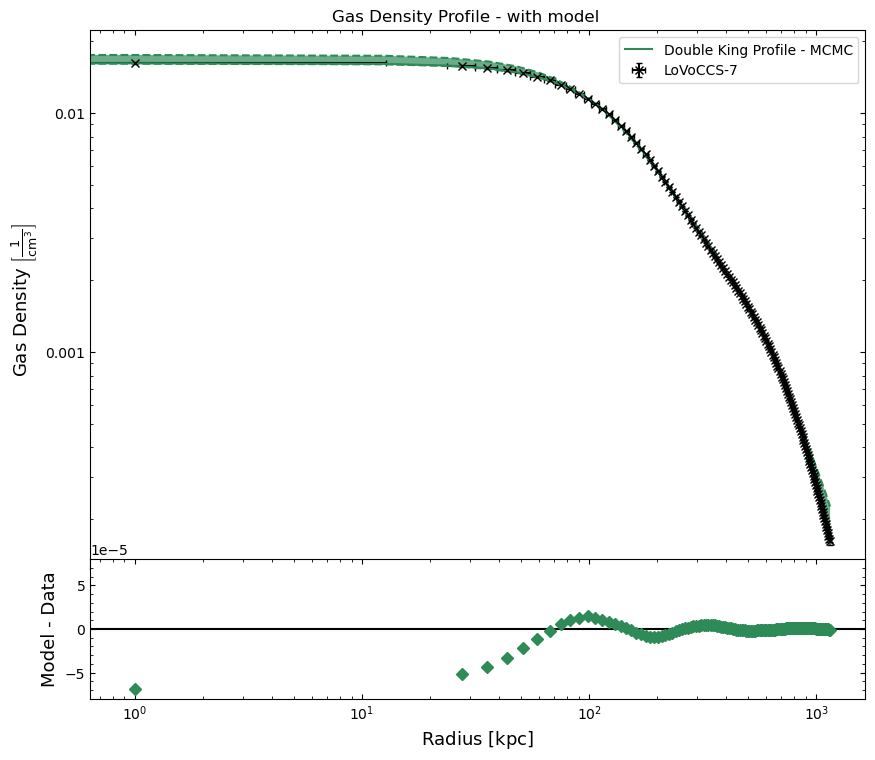

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:776: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  rad_gas_masses = Quantity([self.gas_mass(model, r, fit_method=model_fit_method)[0] for r in rads])


1186.5 kpc
LoVoCCS-10


100%|██████████| 30000/30000 [00:36<00:00, 815.00it/s]


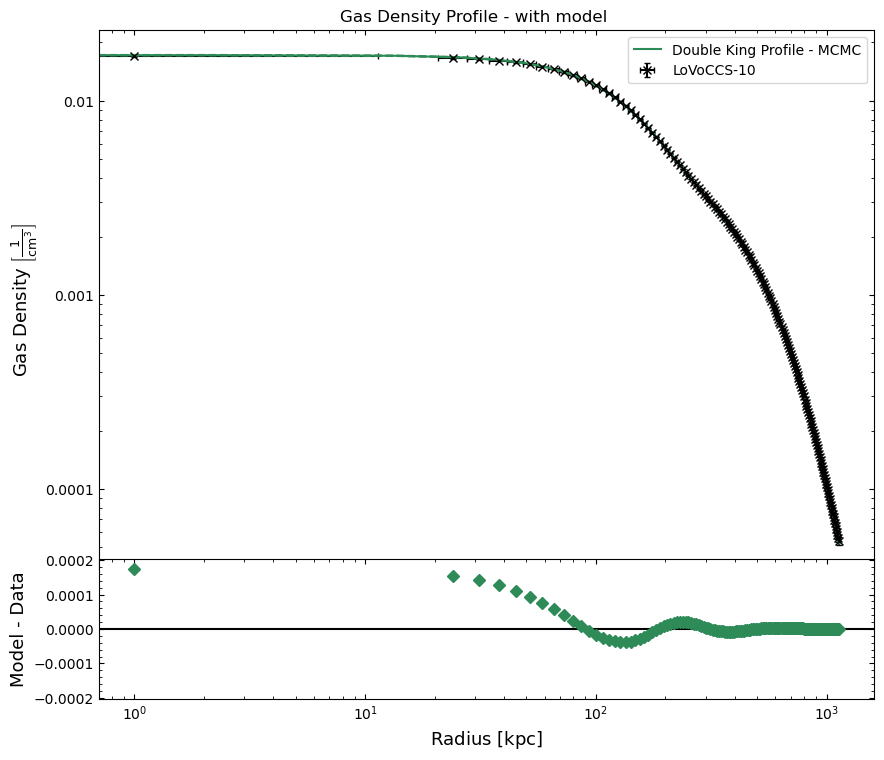

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:776: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  rad_gas_masses = Quantity([self.gas_mass(model, r, fit_method=model_fit_method)[0] for r in rads])


1037.5 kpc
LoVoCCS-13


100%|██████████| 30000/30000 [00:39<00:00, 768.56it/s]


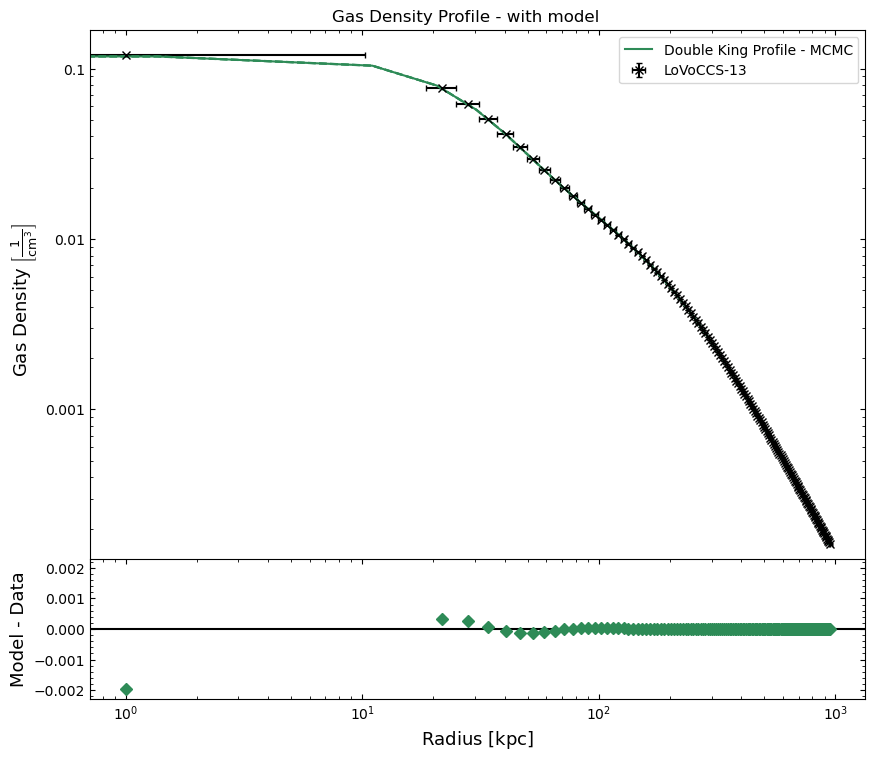

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:776: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  rad_gas_masses = Quantity([self.gas_mass(model, r, fit_method=model_fit_method)[0] for r in rads])


930.5 kpc
LoVoCCS-15


100%|██████████| 30000/30000 [00:33<00:00, 894.61it/s]


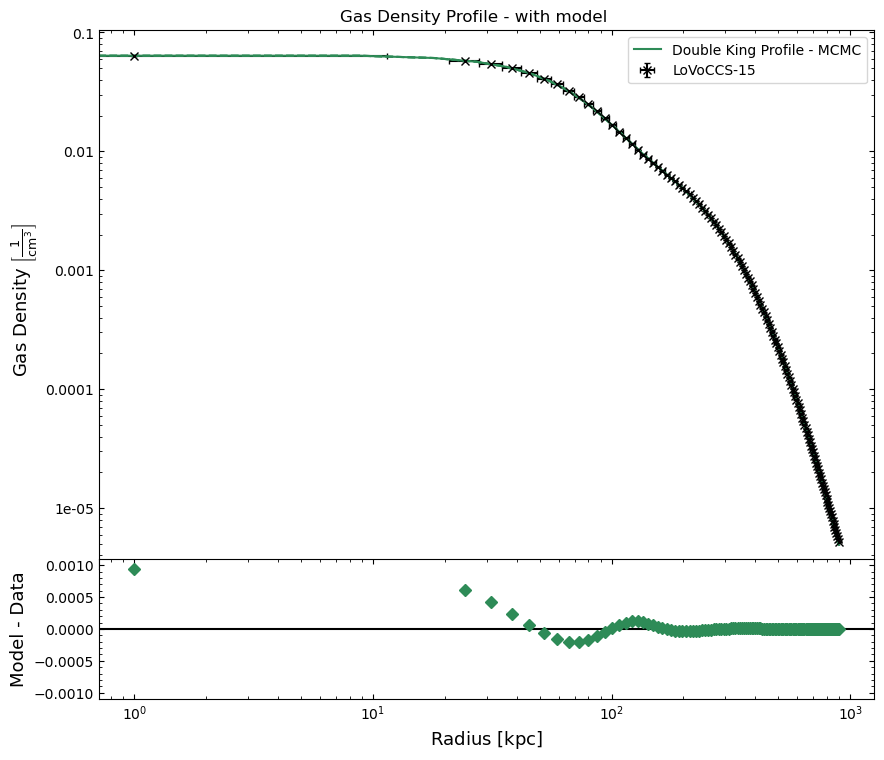

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:776: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  rad_gas_masses = Quantity([self.gas_mass(model, r, fit_method=model_fit_method)[0] for r in rads])


712.5 kpc
LoVoCCS-18


100%|██████████| 30000/30000 [00:39<00:00, 764.55it/s]


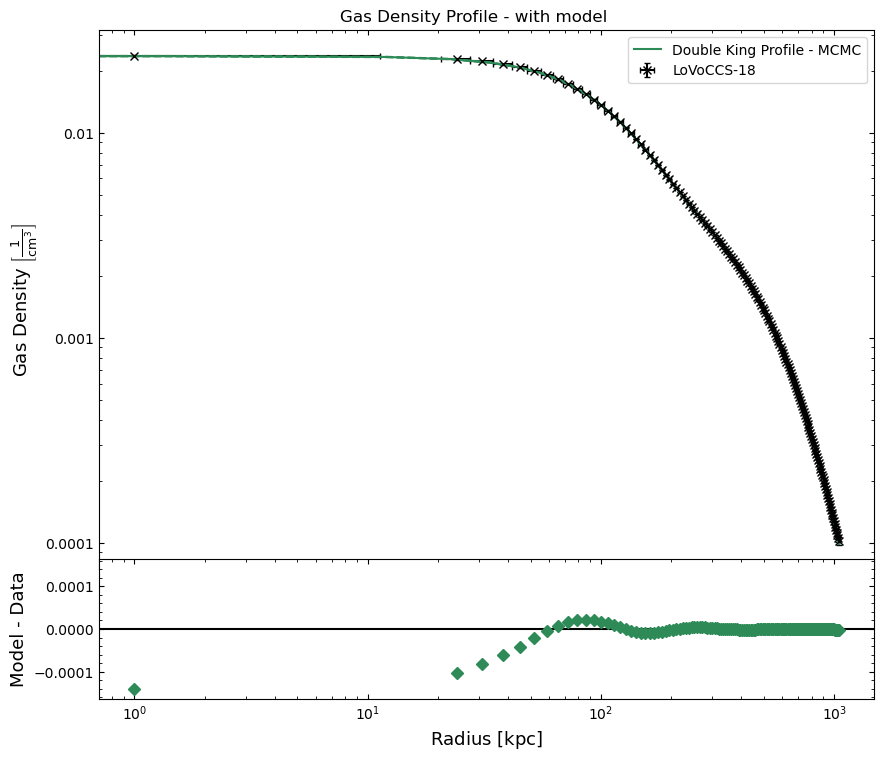

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:776: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  rad_gas_masses = Quantity([self.gas_mass(model, r, fit_method=model_fit_method)[0] for r in rads])


1060.5 kpc
LoVoCCS-22


100%|██████████| 30000/30000 [00:29<00:00, 1029.30it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2945.8761855  3047.89159758 3062.2724026  3414.7602853  3604.2750284
 3115.11894712]


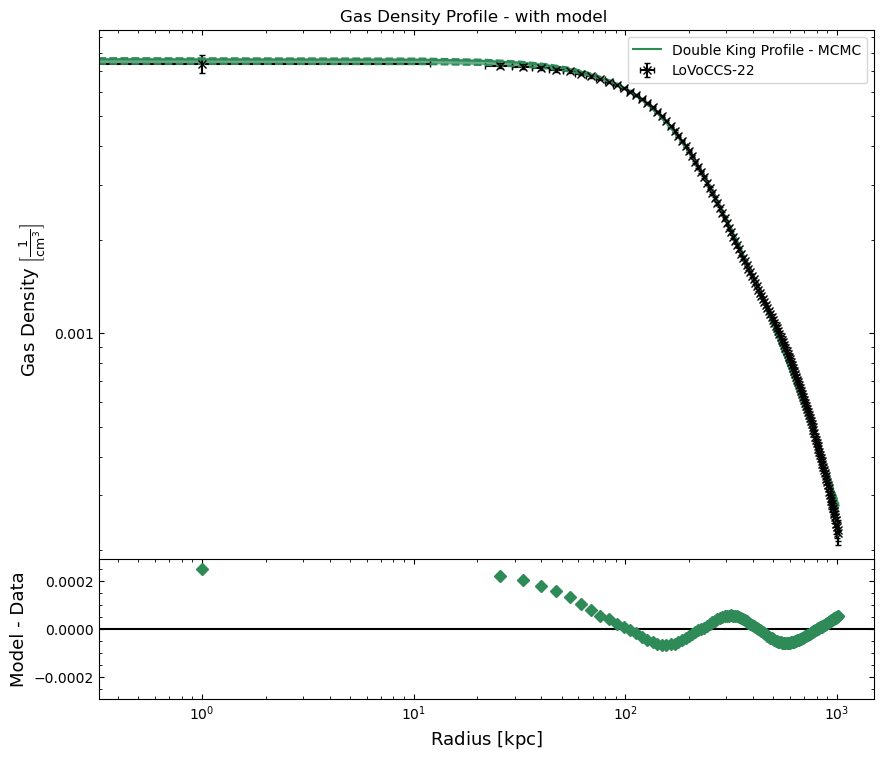

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:776: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  rad_gas_masses = Quantity([self.gas_mass(model, r, fit_method=model_fit_method)[0] for r in rads])


In [ ]:
test_rads = []
for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        print(rel_src.name)
#         rel_src.get_combined_ratemaps().view(rel_src.ra_dec, rel_src.get_interloper_mask(), zoom_in=True)
        dp.fit('double_king')
        dp.view()
        
        test_rad = dp.overdensity_radius(500, 'double_king', rel_src.redshift, rel_src.cosmo, 0.125)
        print(test_rad)
        test_rads.append(test_rad)

In [ ]:
stop

## Measuring and saving gas masses 

Now that the profiles have been fitted with a model, we can integrate with $R_{500}$ as the radius limit and retrieve gas mass measurements. <span style="color:red">This method also supports propagation of $R_{500}$ uncertainties, which can have a large impact on gas mass uncertainties, but they are not available for MCXC $R_{500}$ measurements.</span> 

In [ ]:
gms = []
for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        cur_gms = dp.gas_mass('double_king', rel_src.r500)
        gms.append(cur_gms[0])
    else:
        gms.append(Quantity([np.NaN, np.NaN, np.NaN], 'Msun'))

gms = Quantity(gms)

<span style="color:red">Change the filename once we actually use XMM derived R500s and coordinates</span> 

In [ ]:
data = np.hstack([srcs.names[..., None], gms.to('1e+13 Msun').value])
cols = ['name', 'gm500', 'gm500-', 'gm500+']
gm_df = pd.DataFrame(data, columns=cols)
gm_df.to_csv("../../outputs/results/ltr_r500_gas_masses.csv", index=False)
gm_df